In [3]:
from warnings import filterwarnings; filterwarnings('ignore')
from matplotlib import animation, pyplot as plt
from mpl_toolkits import mplot3d

import seaborn as sns
import numpy   as np
import os

# %matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

from gridworld import GridWorld as TestGridWorld 


In [2]:
np.random.seed(0)

len T:  20
len T:  1
len T:  1
len T:  1


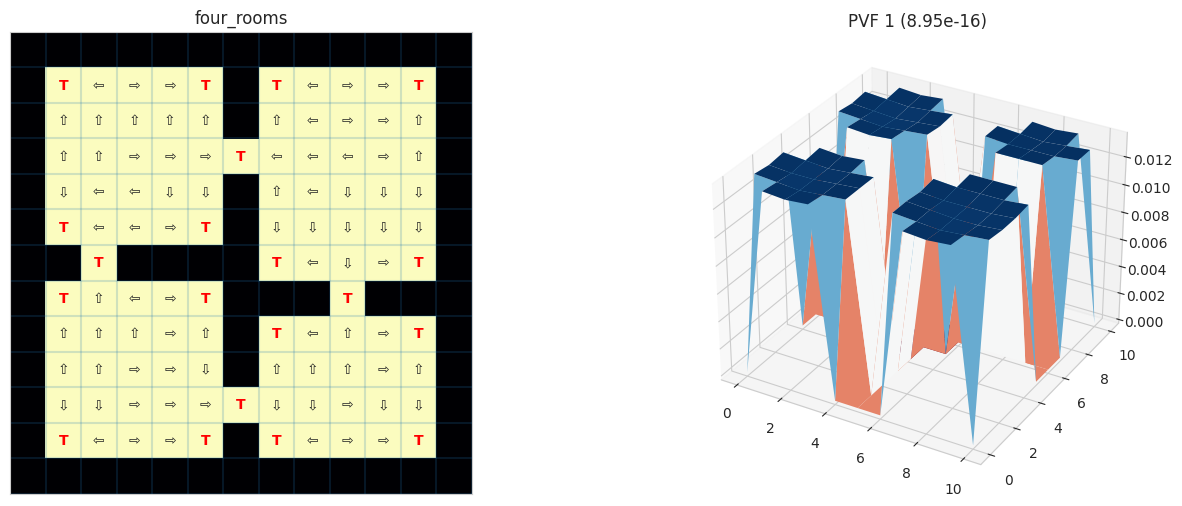

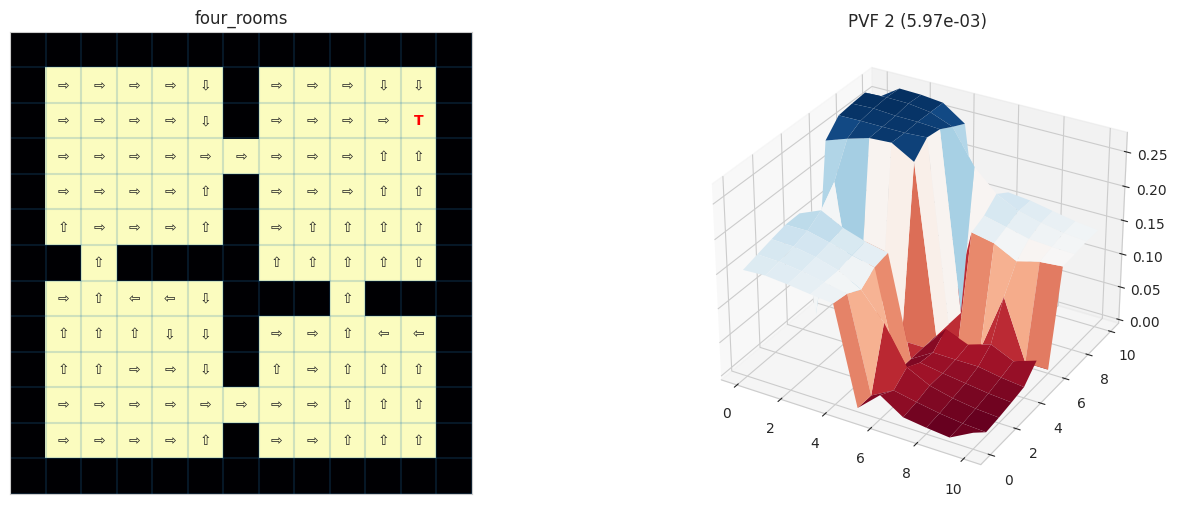

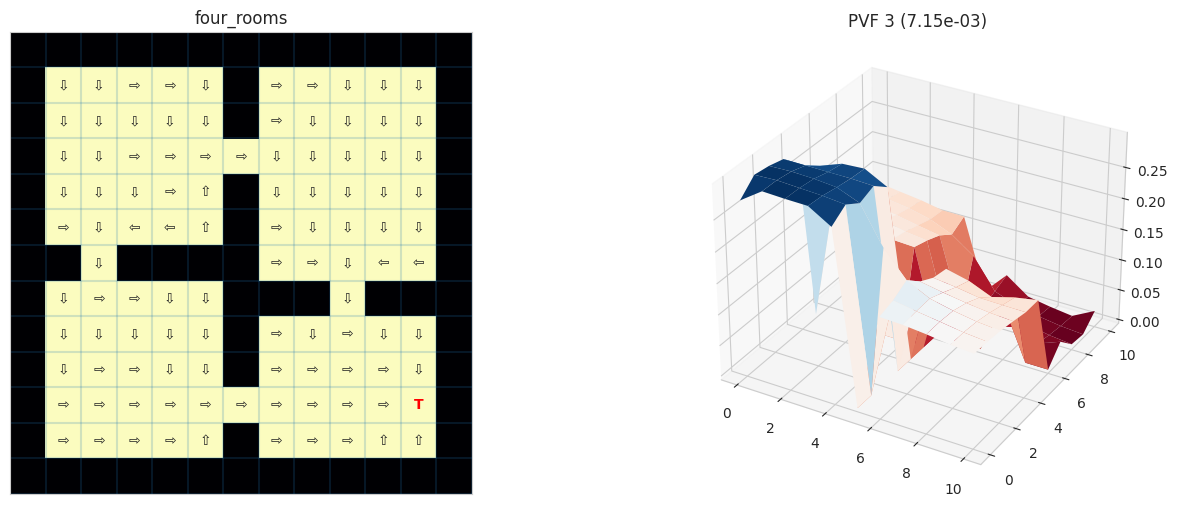

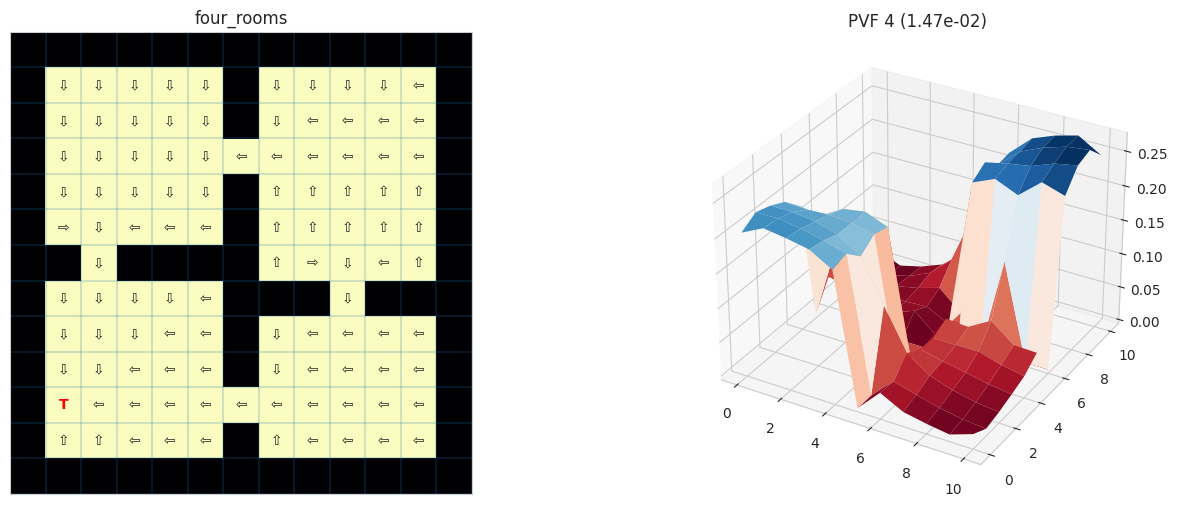

In [3]:
test_env  = TestGridWorld(grid='four_rooms', diffusion='normalised')

for i in range(4):
    V    = test_env.render(i)


In [1]:
# Below defines the gridworlds where space denotes a wall and a non-space
# character denotes an available state. Each has a comment with a number
# reference as to where it comes from.

# 1 (original name 10 x 10)
one_room = """
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
OOOOOOOOOO
"""

# 1
i_maze = """
O             O
OOOOOOOOOOOOOOO
O             O
"""

# 1
four_rooms = """
OOOOO OOOOO
OOOOO OOOOO
OOOOOOOOOOO
OOOOO OOOOO
OOOOO OOOOO
 O    OOOOO
OOOOO   O  
OOOOO OOOOO
OOOOO OOOOO
OOOOOOOOOOO
OOOOO OOOOO
"""

# 2
two_rooms = """
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
        OO      
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
OOOOOOOOOOOOOOOO
"""

# 2
hard_maze = """
OOOOOOOOOOOOOO
OOOOOOOOOOOOOO
      OO
OOOOO OOOOOOOO
OOOOO OOOOOOOO
OO     OO
OOOOOOOOOOOOOO
OOOOOOOOOOOOOO
OO OO OO
OO OO OO OOOOO
OO OO OO OOOOO
OO    OO    OO
OOOOO OOOOOOOO
OOOOO OOOOOOOO
"""

# 3
three_rooms = """
OOOOO OOOOO
OOOOO OOOOO
OOOOOOOOOOO
OOOOO OOOOO
OOOOO OOOOO
OOOOO 
OOOOO OOOOO
OOOOO OOOOO
OOOOOOOOOOO
OOOOO OOOOO
OOOOO OOOOO
"""

class GridWorld():
    """
    GridWorld class for Laplacian computations.
    
    Pre-made grids as illustrated in:
    
        - "A Laplacian Framework for Option Discovery in Reinforcement Learning" (1)
        - "The Laplacian in RL: Learning Representations with Efficient Approximations" (2)
        
    with an additional "three_rooms" grid (3) for further tests
    
    
    ==============
      Parameters
    ==============
    
        grid          : str
                        name of string variable that describes the gridworld
                        space indicates a wall and anything else indicates an availabe state
        
        diffusion     : None, str
                        None          - use the original   laplacian definition
                        "normalised"  - use the normalised laplacian definition
                        "random_walk" - use the normalised random-walk laplacian definition
                    
                        See https://en.wikipedia.org/wiki/Laplacian_matrix#Definition for more details
                    
        pvf_func      : str
                        "eigen"       - eigenvectors
                        "svd"         - left singular vectors
                        
                    
    ==============
        Methods
    ==============
    
        render        : (k, p, gamma)
                        visualises the environment and if k is provided, the proto value function landscape of the state space
                        k             - basis vector index to use as intrinsic reward function
                        p             - deterministic setting i.e. 1 for fully deterministic and (0, 1) for stochastic
                        gamma         - discount rate
                        
        value_iterate : (k, p, gamma)
                        computes the Value table using value iteration
                        k             - basis vector index to use as intrinsic reward function
                        p             - deterministic setting i.e. 1 for fully deterministic and (0, 1) for stochastic
                        gamma         - discount rate
                        
        r             : (k, state, state_prime)
                        computes the intrinsic reward for a state transition
                        k             - basis vector index to use as intrinsic reward function
                        state         - tuple index of where the current state is located
                        state_prime   - tuple index of where the next state is located
    ==============
      Attributes
    ==============
    
        A             : adjacency matrix
        D             : diagonal  matrix which is the row sum of the adjacency matrix
        L             : laplacian matrix
        grid          : numpy.array of the gridworld
        encode        : dictionary translating between adjacency nodes and gridworld coordinates
        lookup        : similar dictionary to encode where the keys and values have been swapped
        e             : Eigen / Singular values
        v             : Eigen / Singular vectors
        
    ==============
    Related Papers
    ==============
    
        https://arxiv.org/pdf/1703.00956.pdf - A Laplacian Framework for Option Discovery in Reinforcement Learning
        https://arxiv.org/pdf/1810.04586.pdf - The Laplacian in RL: Learning Representations with Efficient Approximations
    """
    def __init__(self, grid, diffusion = None, pvf_func = 'eigen'):
        self.name         = grid
        self._grid        = self.get_grid(grid)
        self.diffusion    = diffusion
        
        for variable in 'ADLev':
            # A : Adjacency
            # D : Diagonal
            # L : Laplacian
            # e : Eigen / Singular values
            # v : Eigen / Singular vectors
            setattr(self, f'_{variable}', None)             
        
        self.pvf = getattr(self, f'_{pvf_func}')
        
    def get_grid(self, name):
        if name not in globals():
            raise Exception(f'"{name}" not recognised!')
        string = globals().get(name)
        split  = string.split('\n')[1:-1]
        n      = len(split)
        m      = max(map(len, split))
        grid   = np.zeros((n, m))
        for i, row in enumerate(split):
            grid[i, np.where(np.array([*row]) != ' ')[0]] = 1.
        return np.pad(grid, 1)
    
    def render(self, k = None, p = 1, gamma = 0.99, animate = False, save = True):
        """ renders the gridworld """
        num = self.name
        if k is None:
            fig = plt.figure(figsize = (8, 6), num = num)
            self._render()
            V   = None
        else:
            num  = num + f' PVF {k + 1}'
            fig  = plt.figure(figsize = (16, 6), num = num)
            fig.add_subplot(1, 2, 1)
            V, T = self.value_iterate(k, p, gamma)
            plt.title(self.name)
            self._render()
            self._render_annotate(k, p , gamma, V, T)
            ax   = fig.add_subplot(1, 2, 2, projection = '3d')
            self._render_with_pvf(k, V, ax)
        if animate and k is not None:
            def rotate(i):
                ax.view_init(elev = 30, azim = i * 2)
                return fig,
            anim = animation.FuncAnimation(fig, rotate, frames = 180, interval = 50, blit = True)
            if save:
                try:
                    os.makedirs('results', exist_ok = True)
                    anim.save(os.path.join('results', f'{self.name}-{k + 1}.gif'), writer = 'imagemagick')
                except:
                    print('Failed to save gif!')
            return anim
        return V
            
    def value_iterate(self, k, p = 1, gamma = 0.99, theta = 1e-12):
        """ Value iteration algorithm to compute the Value table """
        self.pvf()
        V = np.zeros_like(self._grid)
        while True:
            T = [] # list of termination states
            old = V.copy()
            for state in zip(*np.where(self._grid)):
                prob = np.eye(4) * p + (1 - p) / 4
                rV   = []
                for state_prime in self.find_adjacent(state):
                    future = state_prime in T
                    rV.append(self.r(k, state, state_prime) + gamma * V[state_prime] * (1 - future))
                V[state] = max(prob.dot(rV))
                if V[state] <= 0:
                    T.append(state)
                    V[state] = 0
            err = np.absolute(V - old).max()
            if err < theta: break
        return V, T

    def r(self, k, state, state_prime):
        """ Intrinsic reward function """
        return (-1) ** 2 * (self._v[self.lookup[state_prime],k] - self._v[self.lookup[state],k])
    
    def find_adjacent(self, state):
        """ computes neighbouring states """
        return list(self._find_adjacent(state)) # down, right, up, left (⇩⇨⇧⇦)
    
    @property
    def grid(self):
        """ Numpy array of grid """
        return self._grid
    
    @property
    def A(self):
        """ adjacency matrix """
        if isinstance(self._A, np.ndarray):
            return self._A
        states  = zip(*np.where(self._grid))
        encode  = self._encode = dict(enumerate(states))
        lookup  = self._lookup = {v : k for k, v in encode.items()}
        self._A = np.zeros((len(encode),) * 2)
        for i, state in encode.items():
            for adj in self.find_adjacent(state):
                j = lookup[adj]
                self._A[i, j] = 1
        return self._A

    @property
    def D(self):
        """ diagonal matrix which is the row sum of the adjacency matrix """
        if isinstance(self._D, np.ndarray):
            return self._D
        self._D = np.diag(self.A.sum(axis = 1))
        return self._D
    
    @property
    def L(self):
        """ laplacian matrix """
        if isinstance(self._L, np.ndarray):
            return self._L
        if self.diffusion is None:
            self._L = self.D - self.A
            return self._L
        elif self.diffusion in ['normalised', 'normalized']:
            rD = np.diag(1 / np.diag(np.sqrt(self.D)))
            self._L = np.eye(len(self.A)) - rD @ self.A @ rD
            return self._L
        elif self.diffusion == 'random_walk':
            self._L = np.eye(len(self.A)) - np.diag(1 / np.diag(self.D)) @ self.A
            return self._L
        raise Exception(f'Diffusion "{self.diffusion}" not recognised!')
        
    @property
    def encode(self):
        """ Dictionary encoding (int) : state (tuple)"""
        if '_encode' in self.__dict__:
            return self._encode
        raise Exception('Adjacency matrix needs to be computed first!')
        
    @property
    def lookup(self):
        """ Dictionary state (tuple) : encoding (int)"""
        if '_lookup' in self.__dict__:
            return self._lookup
        raise Exception('Adjacency matrix needs to be computed first!')
        
    @property
    def e(self):
        """ Eigen / Singular values """
        if isinstance(self._e, np.ndarray):
            return self._e
        self.pvf()
        return self._e
    
    @property
    def v(self):
        """ Eigen / Singular vectors """
        if isinstance(self._v, np.ndarray):
            return self._v
        self.pvf()
        return self._v
    
    def _render(self):
        """ Renders the environment """
        plt.imshow(self._grid, cmap = 'magma')
        for i in range(self._grid.shape[0]):
            plt.hlines(i + 0.5, -0.5, self._grid.shape[1] - 0.5, alpha = 0.2)
        for j in range(self._grid.shape[1]):
            plt.vlines(j + 0.5, -0.5, self._grid.shape[0] - 0.5, alpha = 0.2)
        plt.xticks([])
        plt.yticks([])
        
    def _render_annotate(self, k, p, gamma, V, T):
        """ Overlays the policy over the environment """
        policy = np.zeros_like(V, dtype = str)

        for state in zip(*np.where(self.grid)):
            values = [self.r(k, state, state_prime) + gamma * V[state_prime] for state_prime in self.find_adjacent(state)]
            if len(np.unique(values)) > 1:
                policy[state] = '⇩⇨⇧⇦'[np.argmax(values)]
        
        for state in zip(*np.where(self.grid)):
            if state in T:
                plt.annotate(r'$\mathbf{T}$', state[::-1], va = 'center', ha = 'center', c = 'r')
            else:
                plt.annotate(policy[state], state[::-1], va = 'center', ha = 'center')
    
    def _render_with_pvf(self, k, V, ax):
        """ Renders the Value table based on a given PVF """
        plt.title(f'PVF {k + 1} ({self.e[k]:.2e})', y = 1.08)
        X, Y = np.meshgrid(range(V.shape[1] - 2), range(V.shape[0] - 2))
        ax.plot_surface(X, Y, V[1:-1,1:-1], cmap = 'RdBu', edgecolor='none')
    
    def _find_adjacent(self, state):
        """ helper function for find_adjacent method """
        i, j = state
        yield (i + 1, j) if self._grid[i + 1, j] else (i, j)
        yield (i, j + 1) if self._grid[i, j + 1] else (i, j)
        yield (i - 1, j) if self._grid[i - 1, j] else (i, j)
        yield (i, j - 1) if self._grid[i, j - 1] else (i, j)
        
    def _eigen(self):
        """ computes values and basis vectors using the eigenvalue decomposition """
        e, v    = np.linalg.eig(self.L)
        s       = np.sign(e)
        o       = e.argsort()
        self._e = e[o] * s[o]
        self._v = v[:,o] * s[o]
        
    def _svd(self):
        """ computes values and basis vectors using the singular value decomposition """
        v, e,_  = np.linalg.svd(self.L, full_matrices = False)
        self._e = e[::-1]
        self._v = v[:,::-1]

In [4]:
env = GridWorld(grid='four_rooms', diffusion=None)

env.pvf()

In [6]:
env.e

array([4.31494571e-15, 2.29034969e-02, 2.71564588e-02, 5.61568424e-02,
       2.84739465e-01, 3.52017451e-01, 3.68283039e-01, 3.76361988e-01,
       4.08104426e-01, 4.29956517e-01, 4.83126471e-01, 6.00549195e-01,
       6.51205008e-01, 7.38164179e-01, 8.08280186e-01, 9.56547116e-01,
       9.68094274e-01, 1.14757263e+00, 1.18299131e+00, 1.25788184e+00,
       1.31344895e+00, 1.38645627e+00, 1.41095624e+00, 1.45067165e+00,
       1.50740443e+00, 1.62623710e+00, 1.68060326e+00, 1.73450819e+00,
       1.77588294e+00, 1.83824484e+00, 1.87368105e+00, 1.96403431e+00,
       2.04151255e+00, 2.08962795e+00, 2.11418267e+00, 2.33742571e+00,
       2.45328870e+00, 2.49739663e+00, 2.61583060e+00, 2.62319697e+00,
       2.62558037e+00, 2.68519311e+00, 2.69535093e+00, 2.72763181e+00,
       2.74416724e+00, 2.86068932e+00, 2.88888354e+00, 2.94910937e+00,
       3.00000000e+00, 3.07391764e+00, 3.10835864e+00, 3.19594048e+00,
       3.21671337e+00, 3.26991573e+00, 3.39945632e+00, 3.41608686e+00,
      

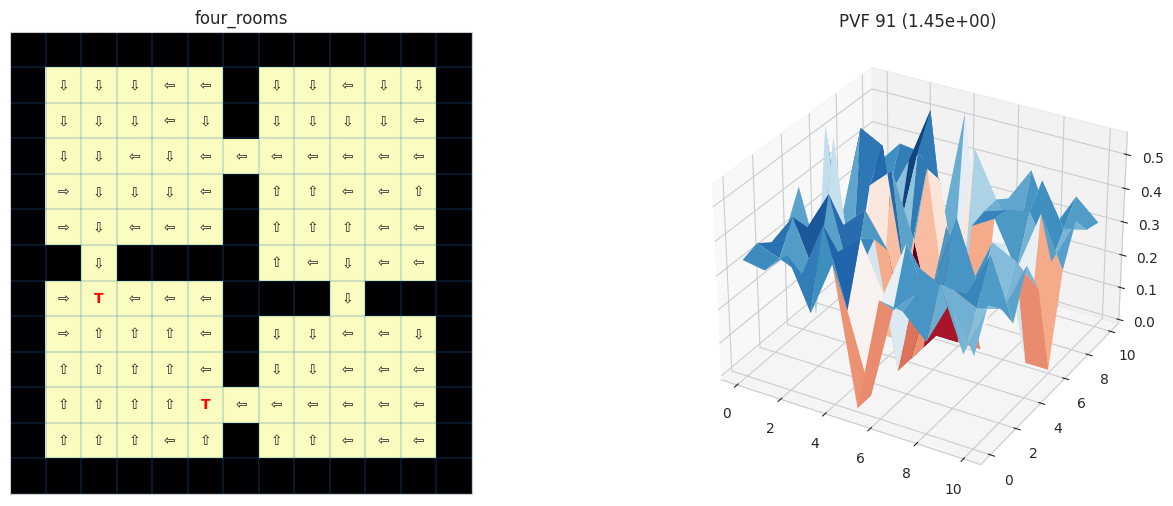

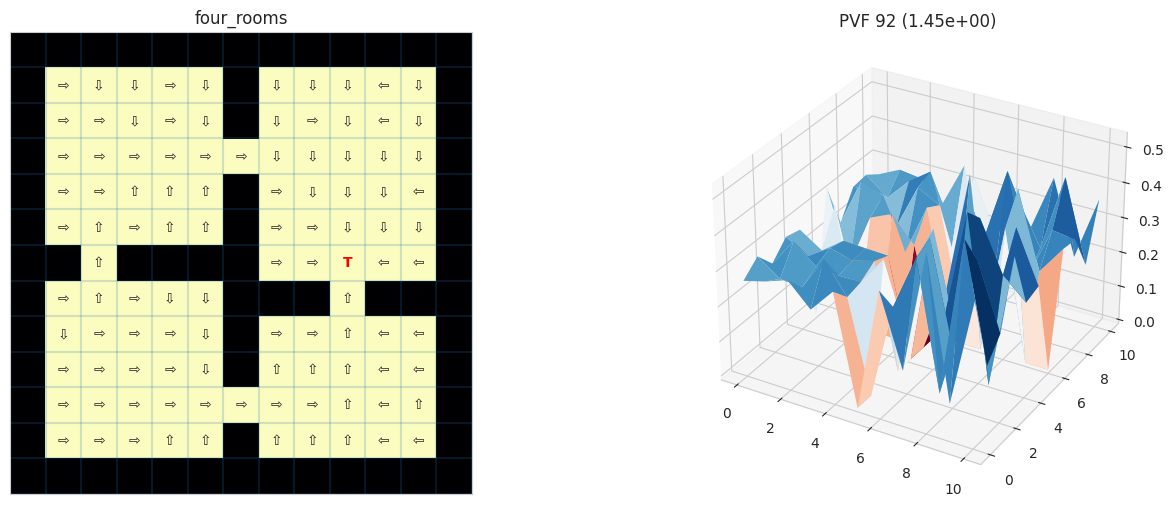

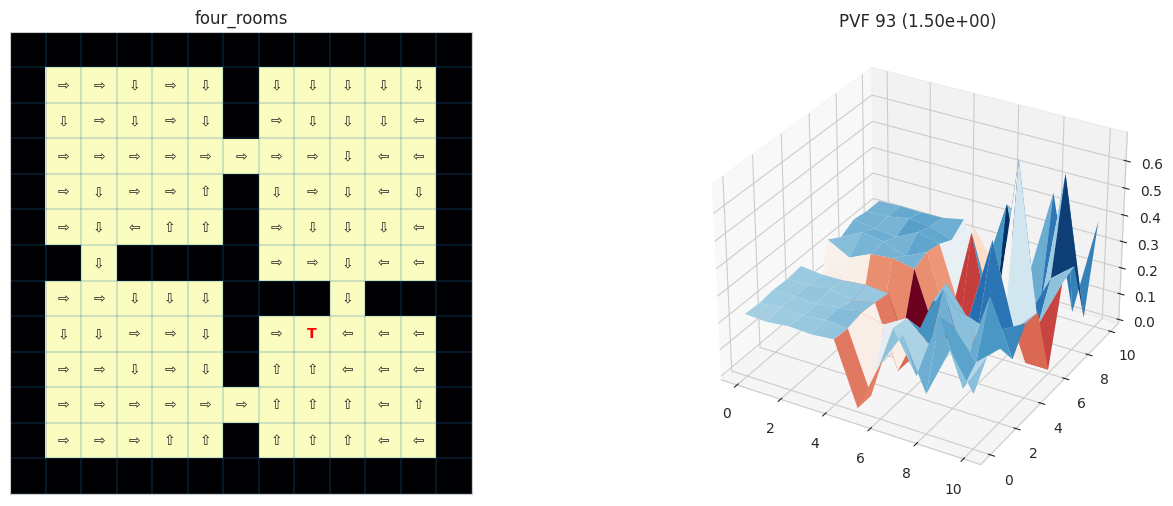

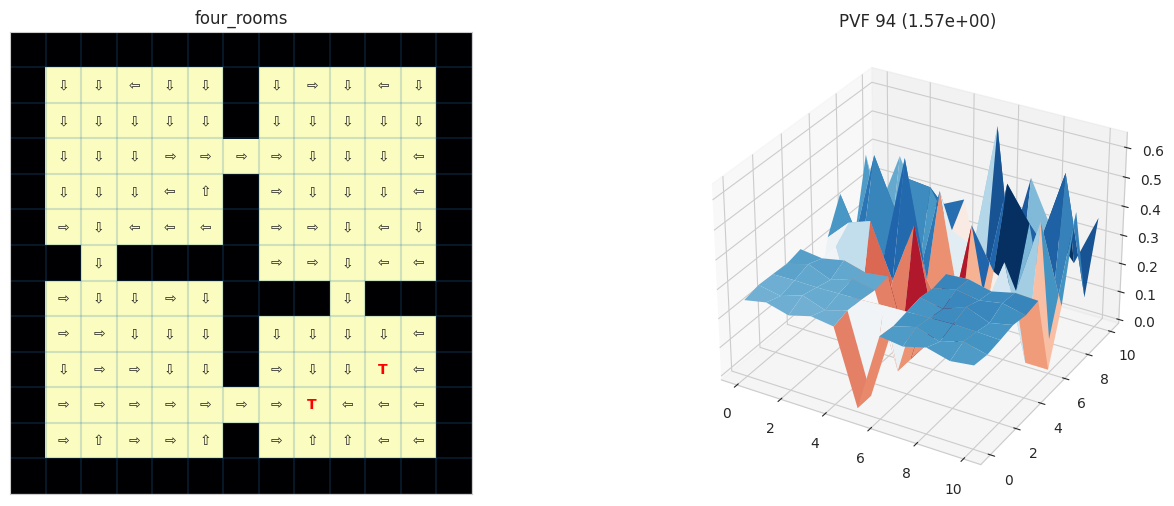

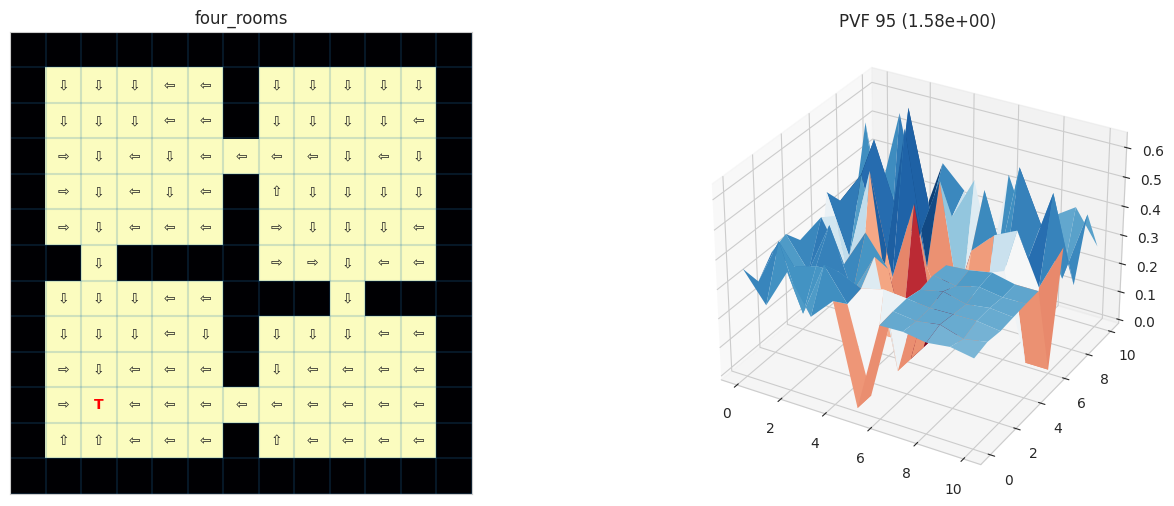

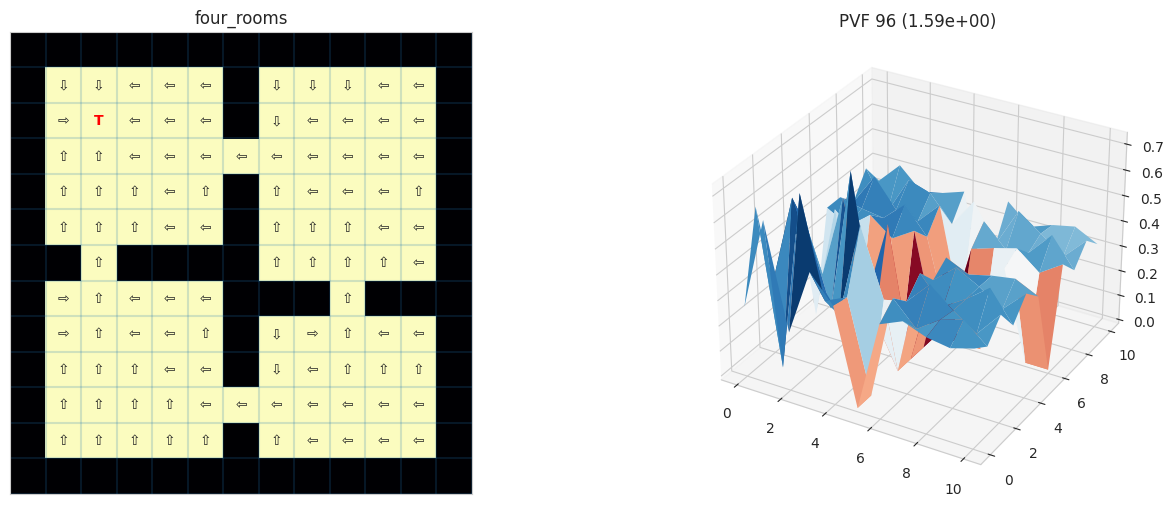

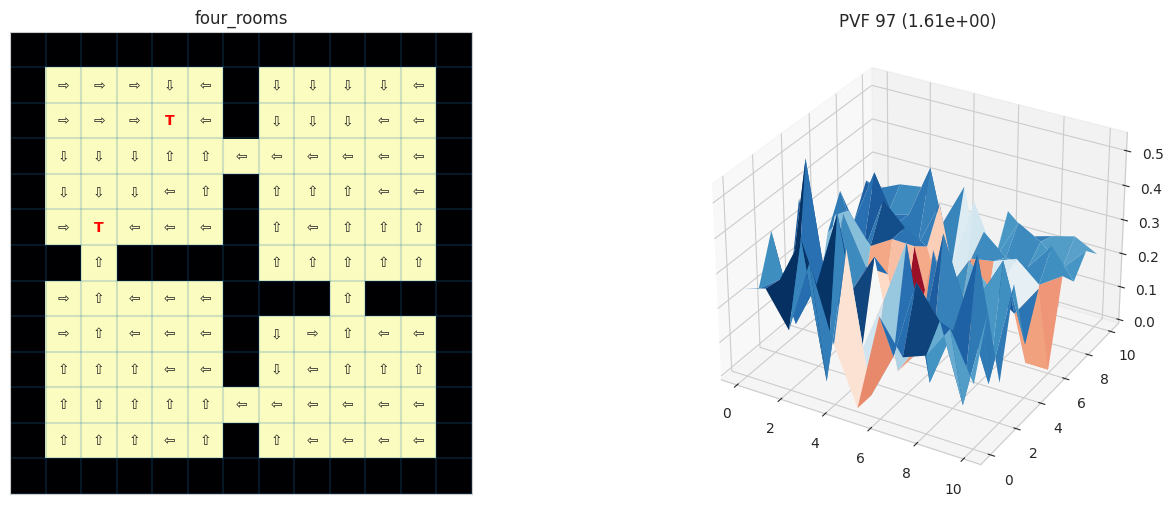

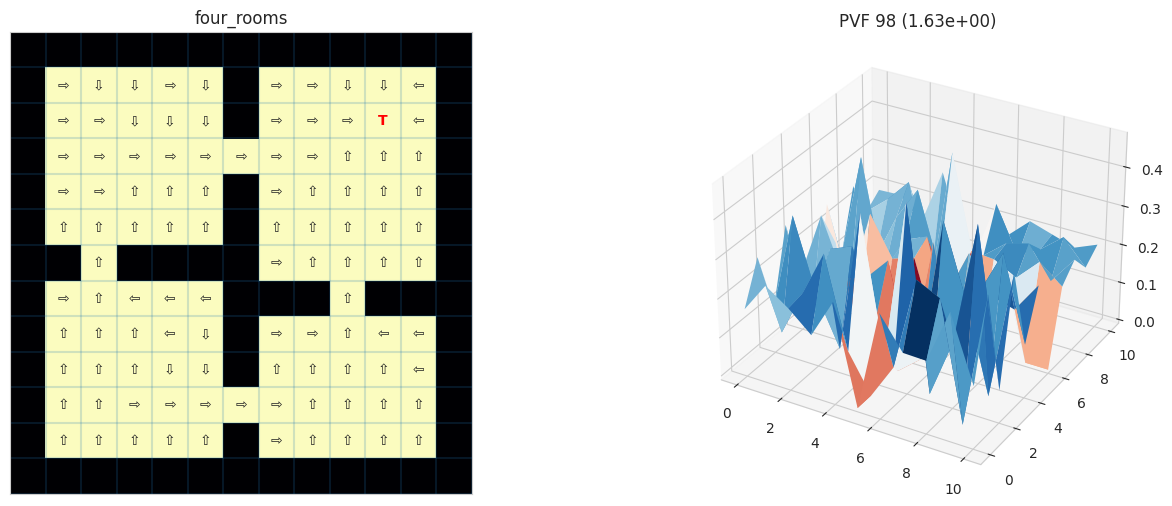

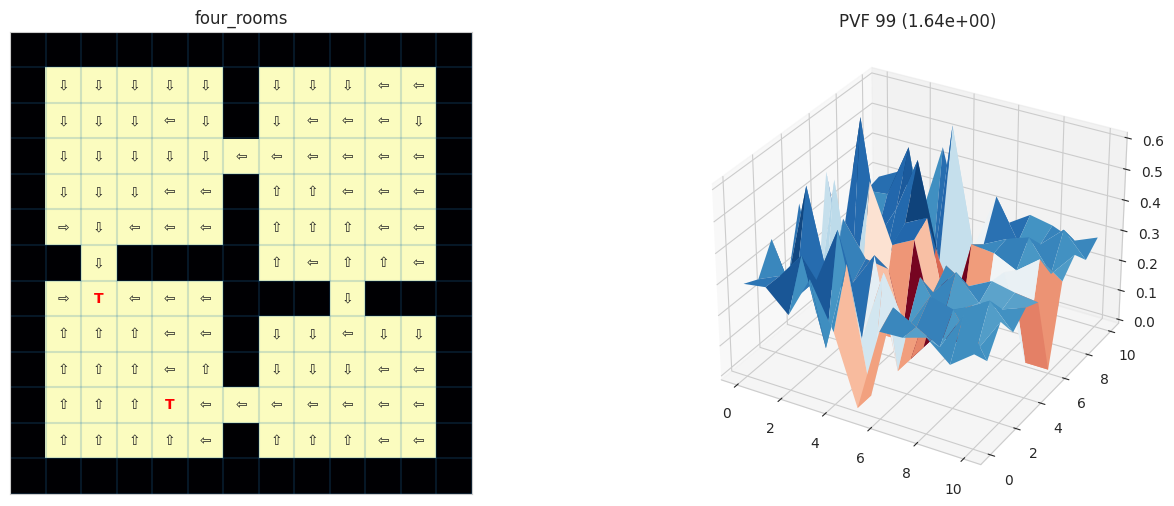

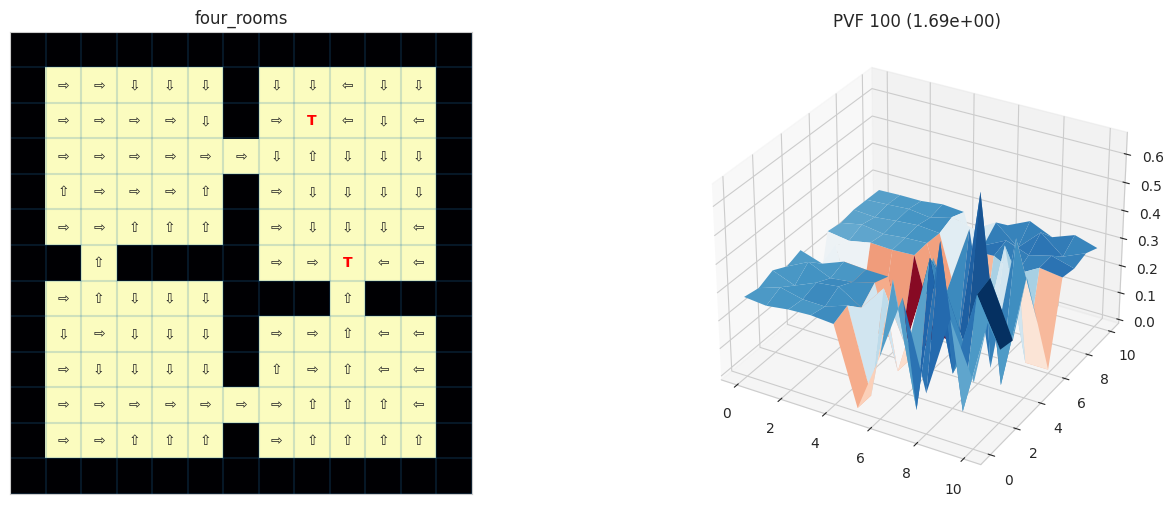

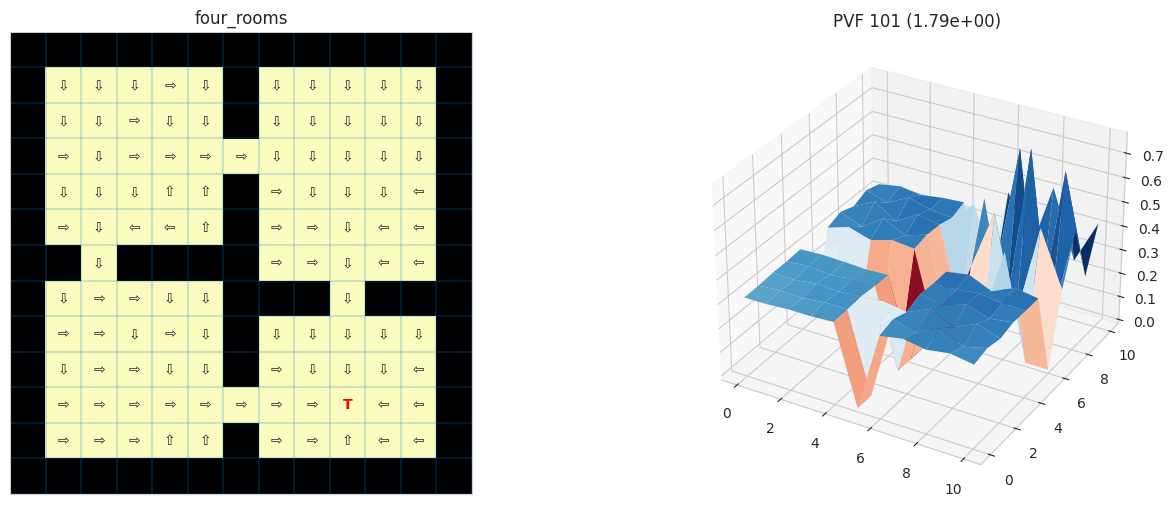

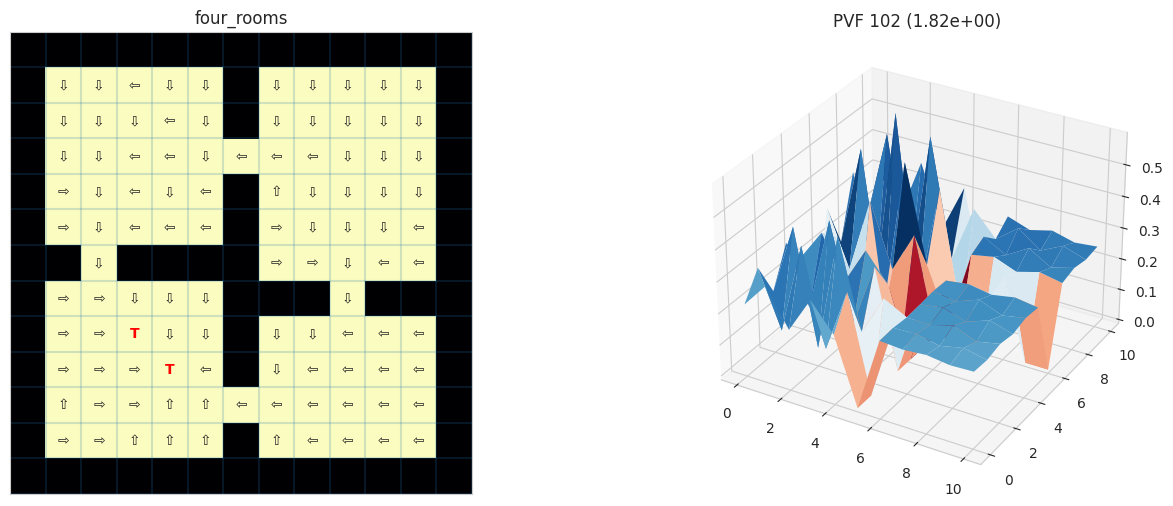

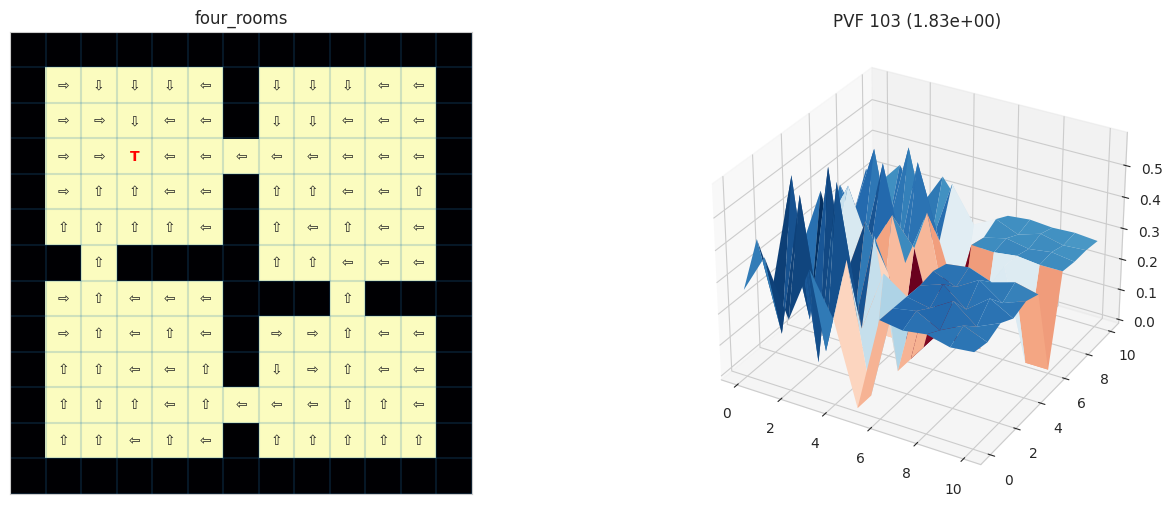

In [7]:
env  = GridWorld(grid='four_rooms', diffusion='normalised')

for i in range(90, 103):
    V = env.render(i)


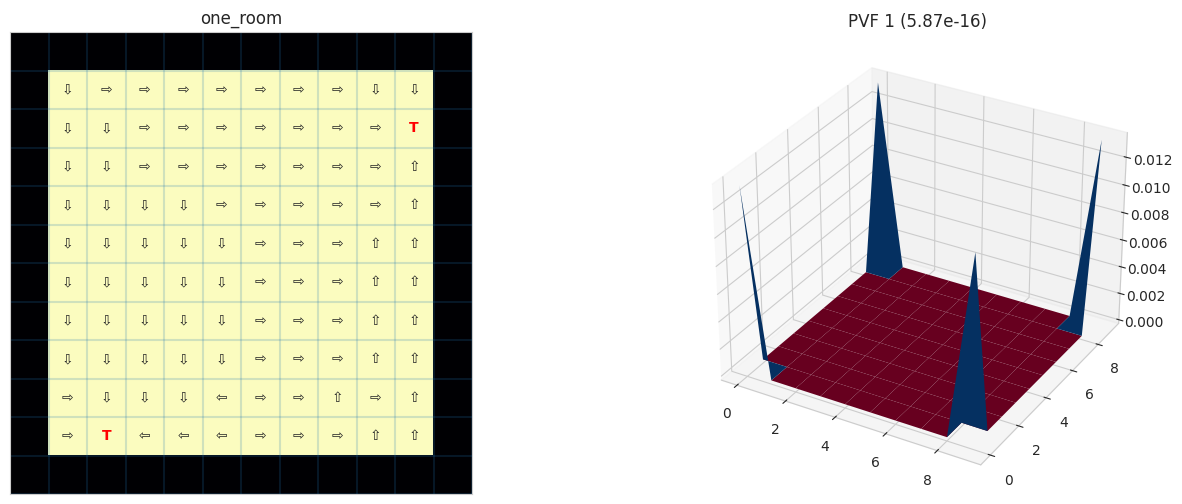

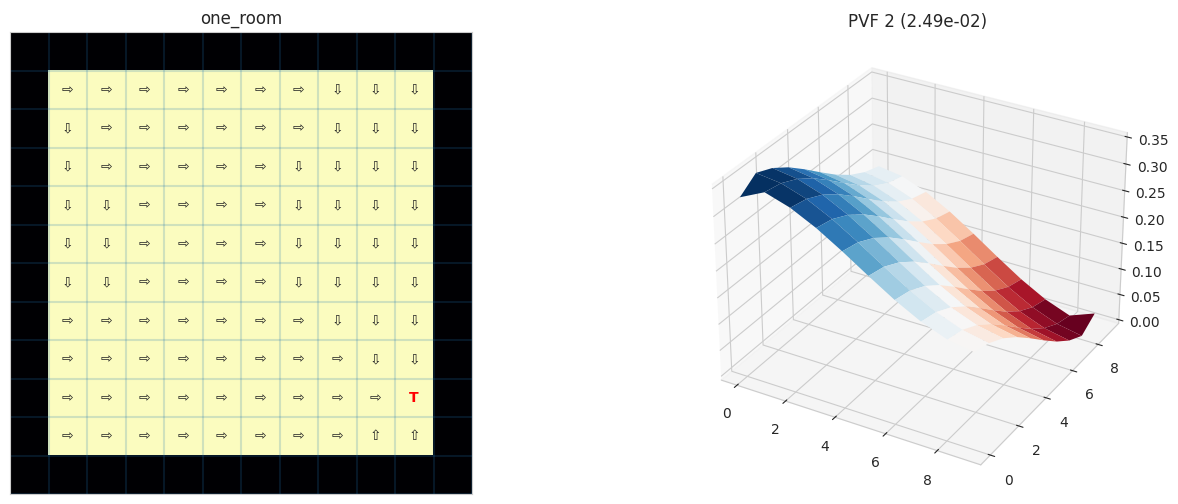

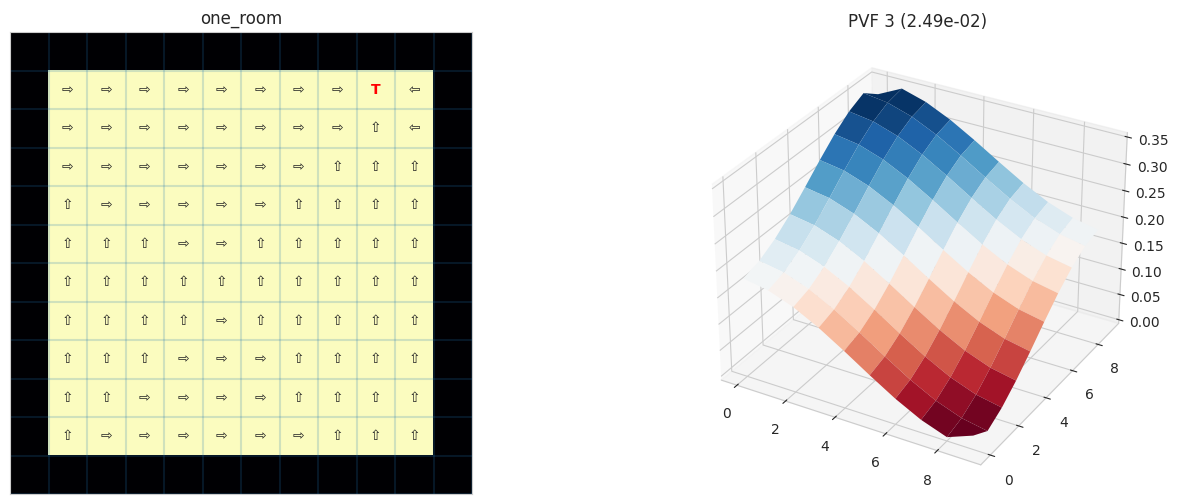

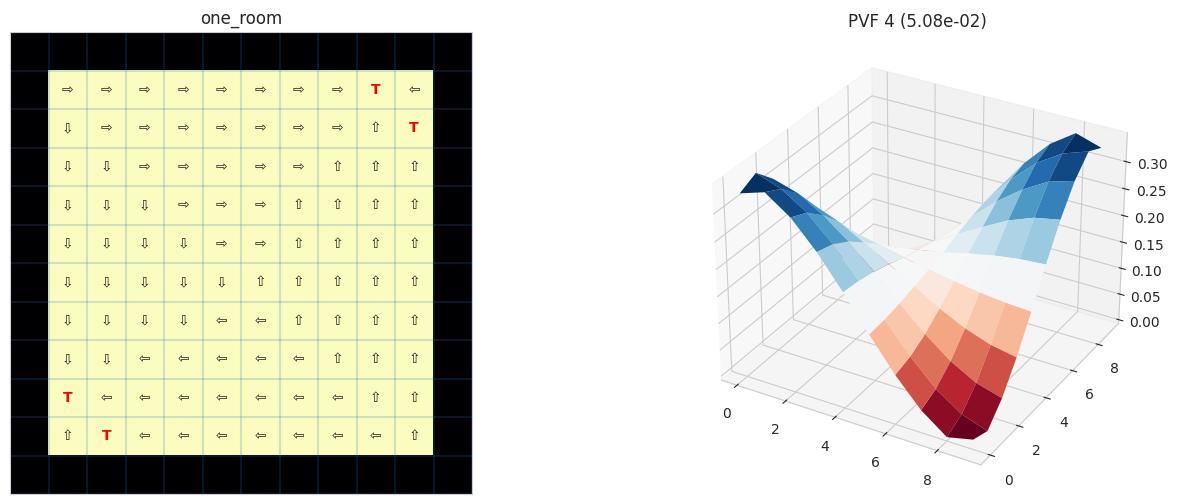

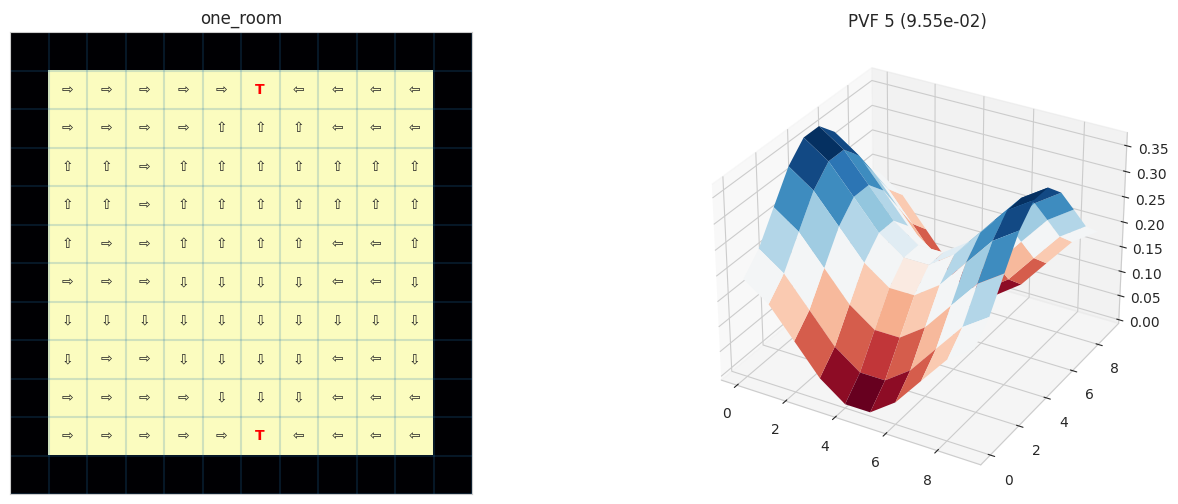

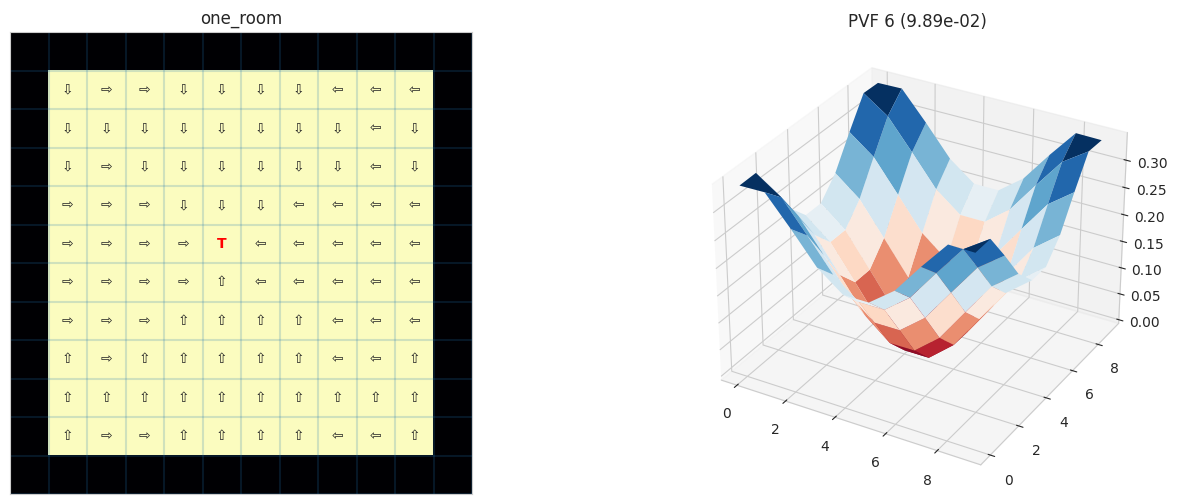

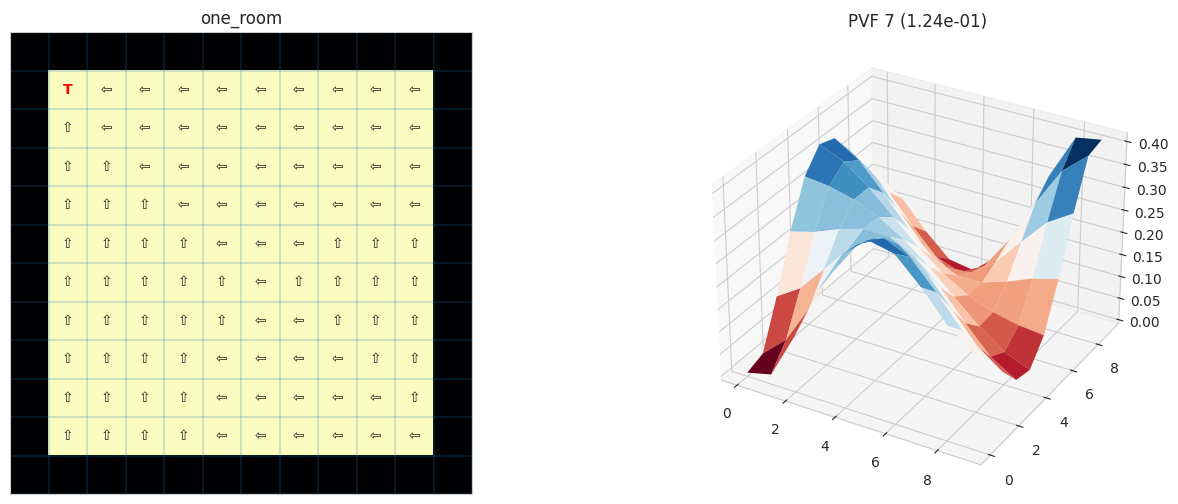

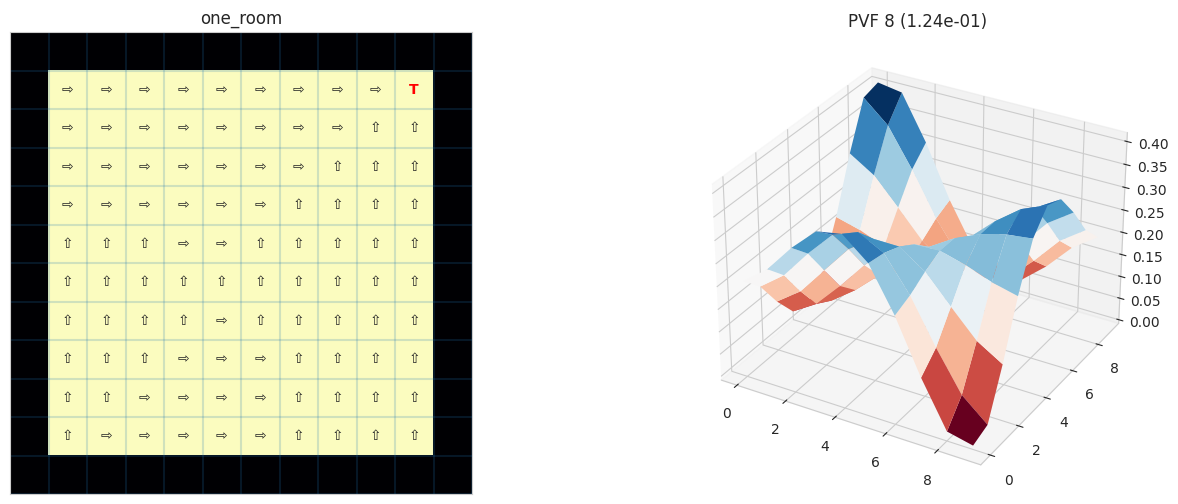

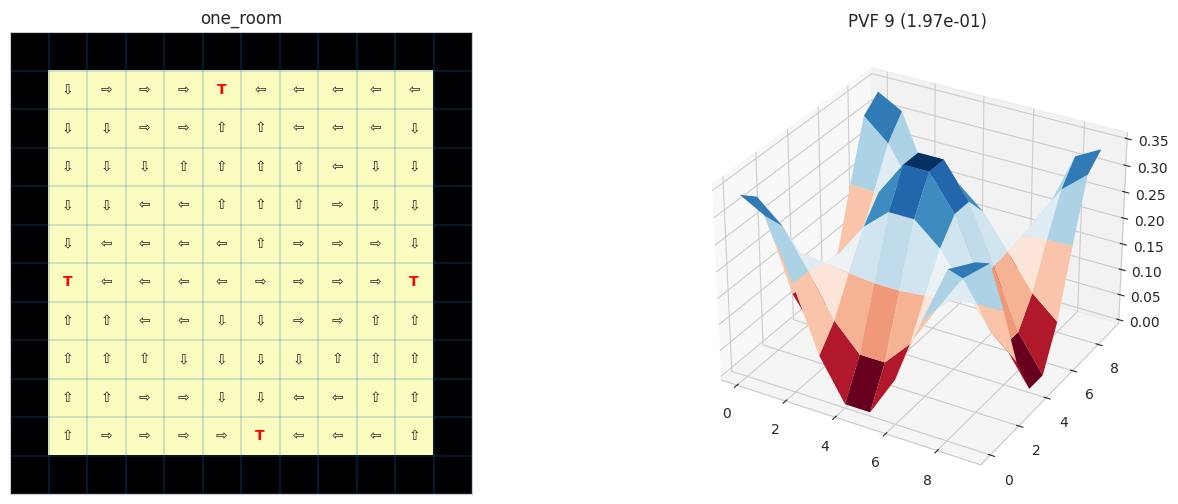

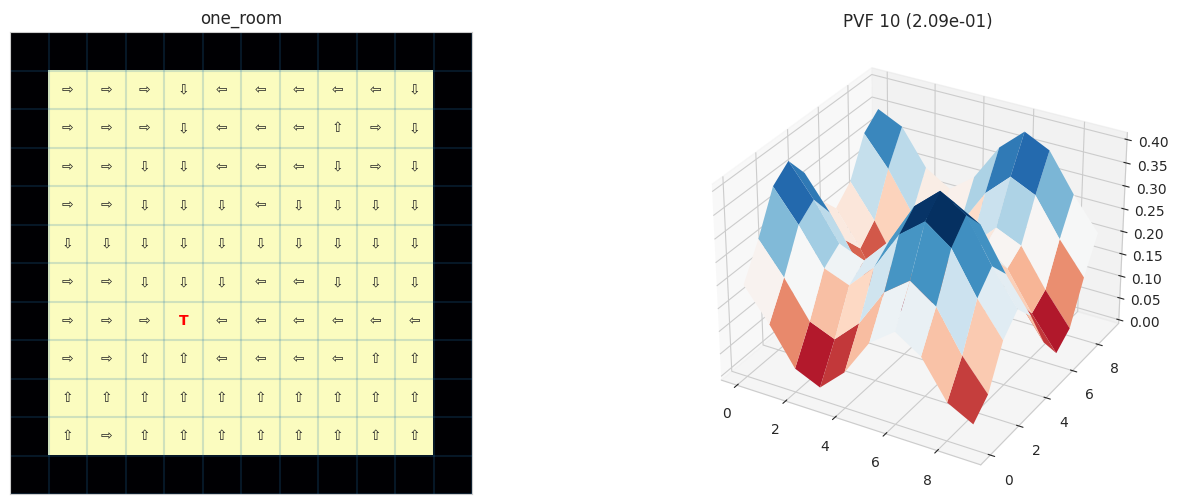

In [6]:
env  = GridWorld(grid = 'one_room', diffusion = 'normalised')

for i in range(10):
    V    = env.render(i)

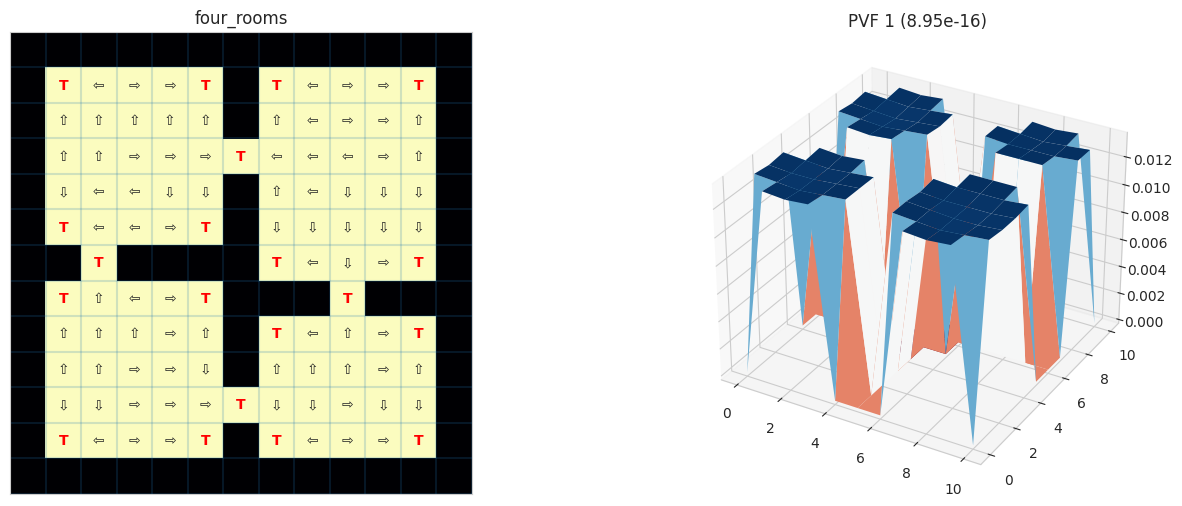

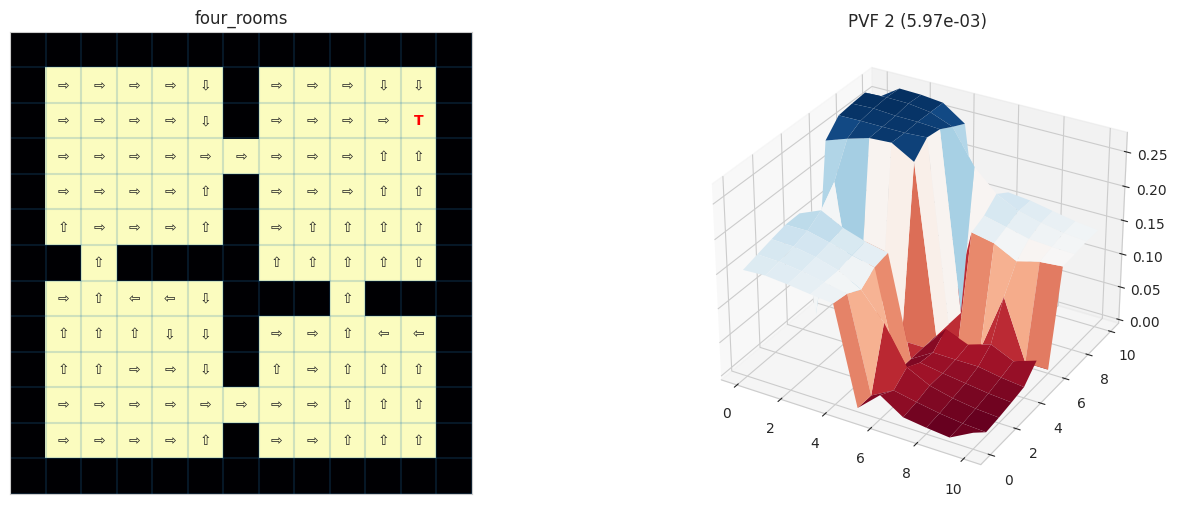

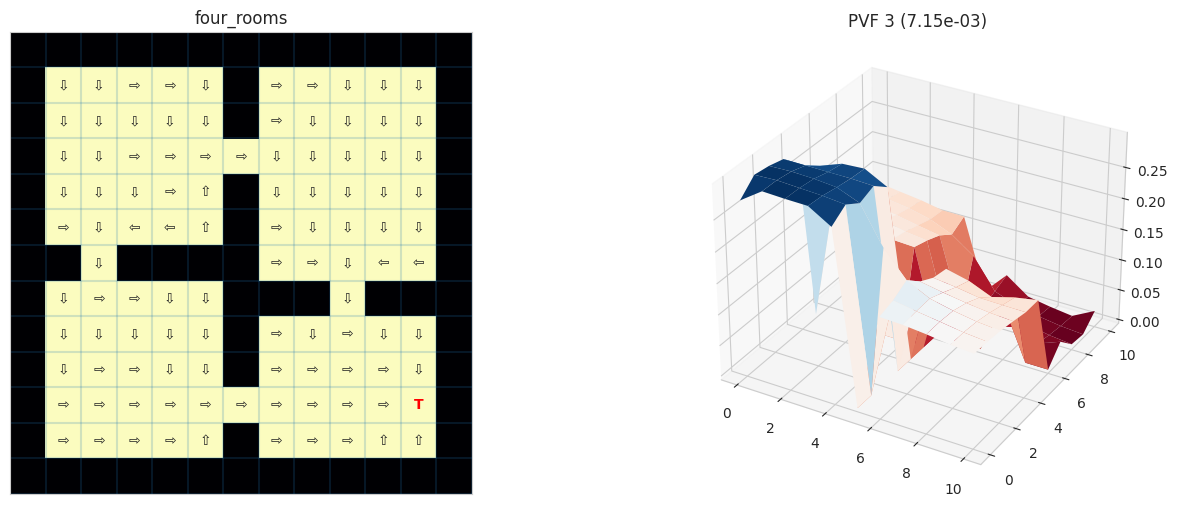

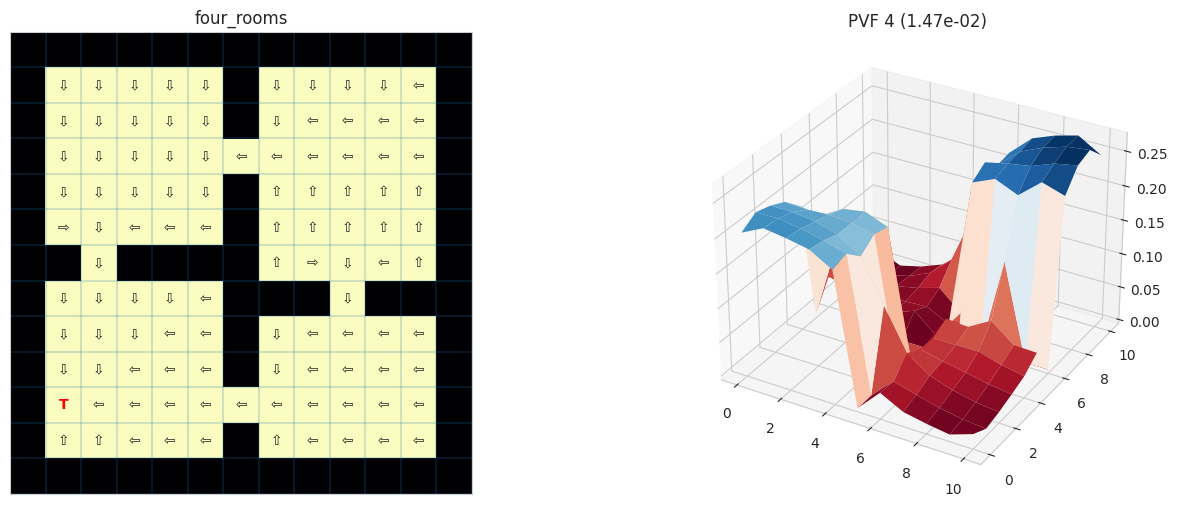

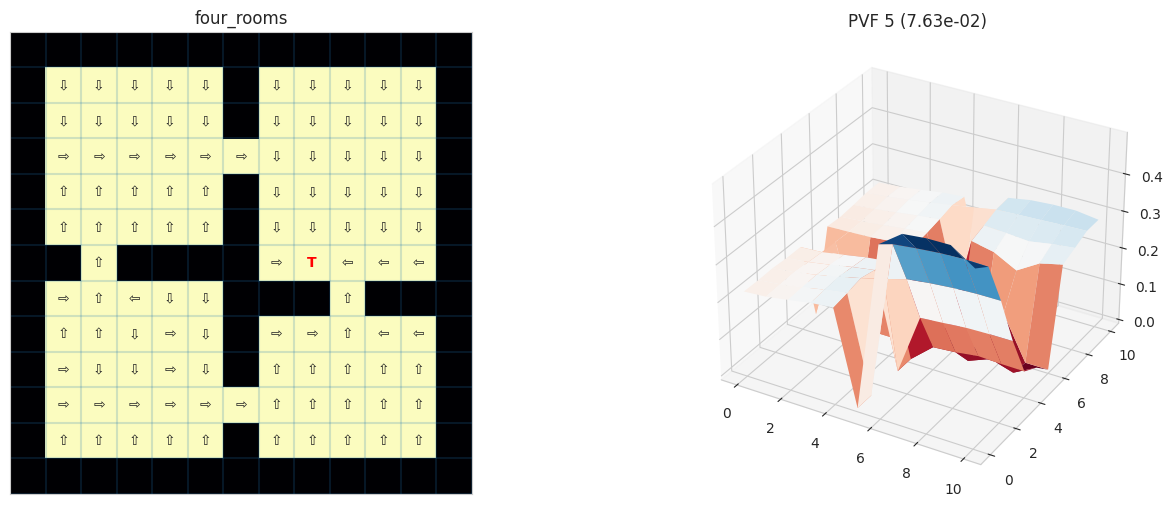

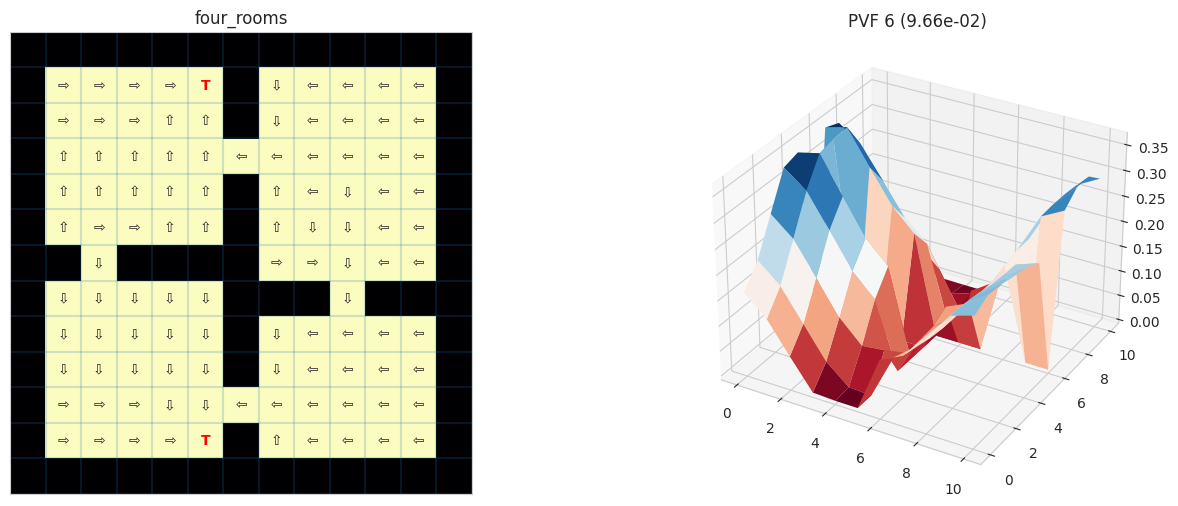

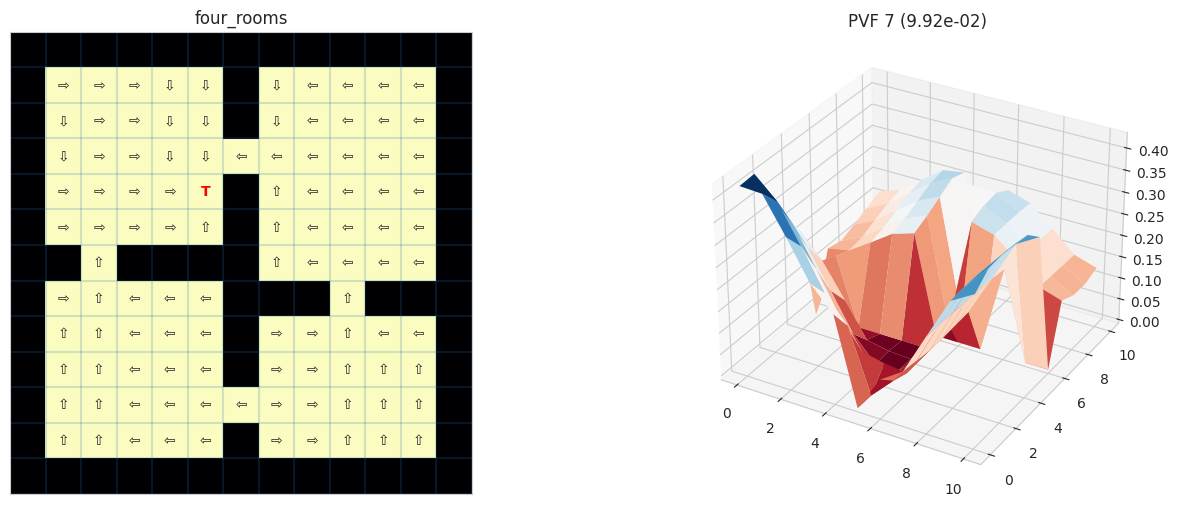

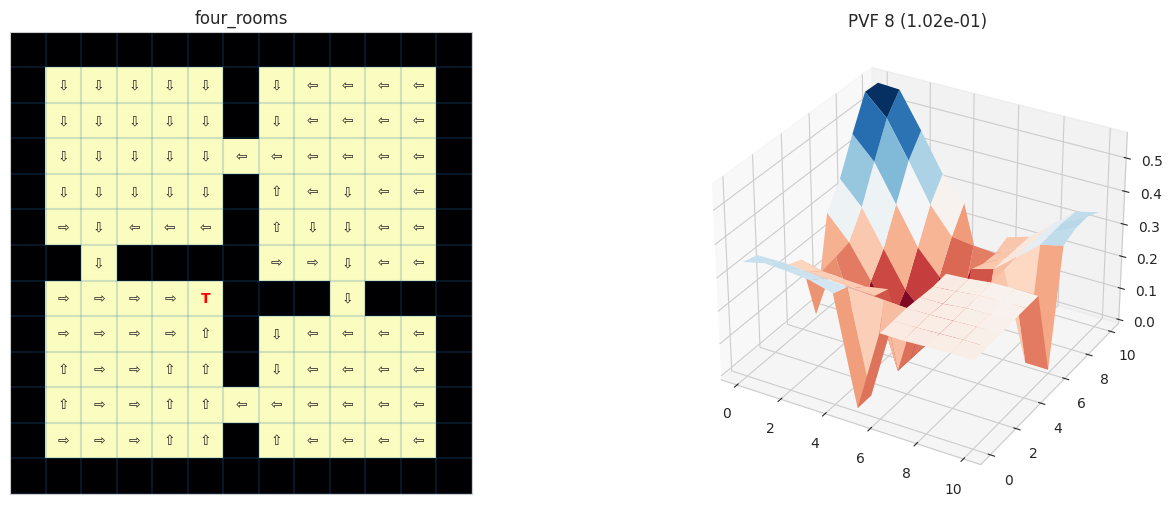

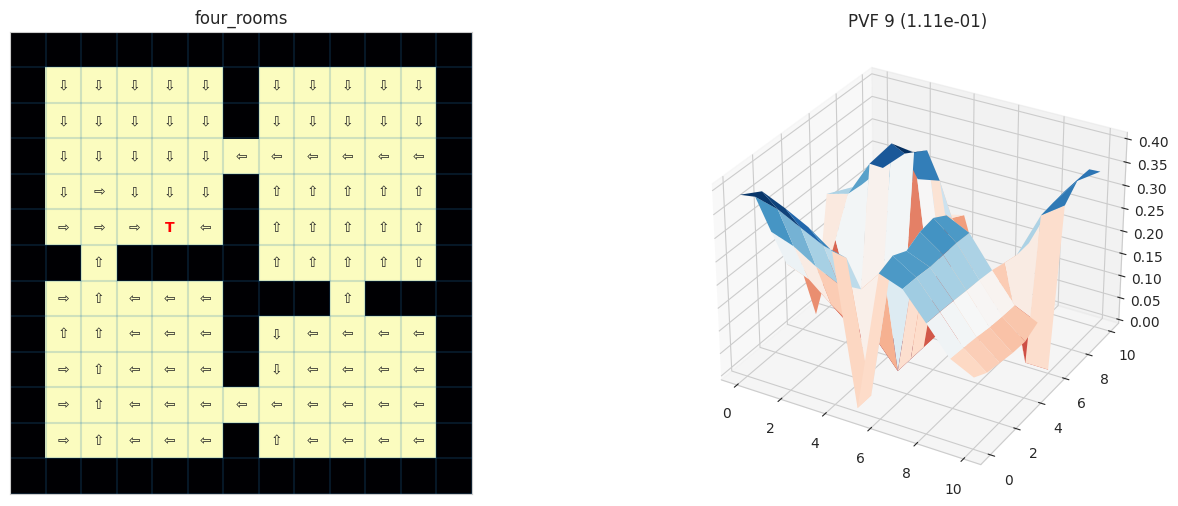

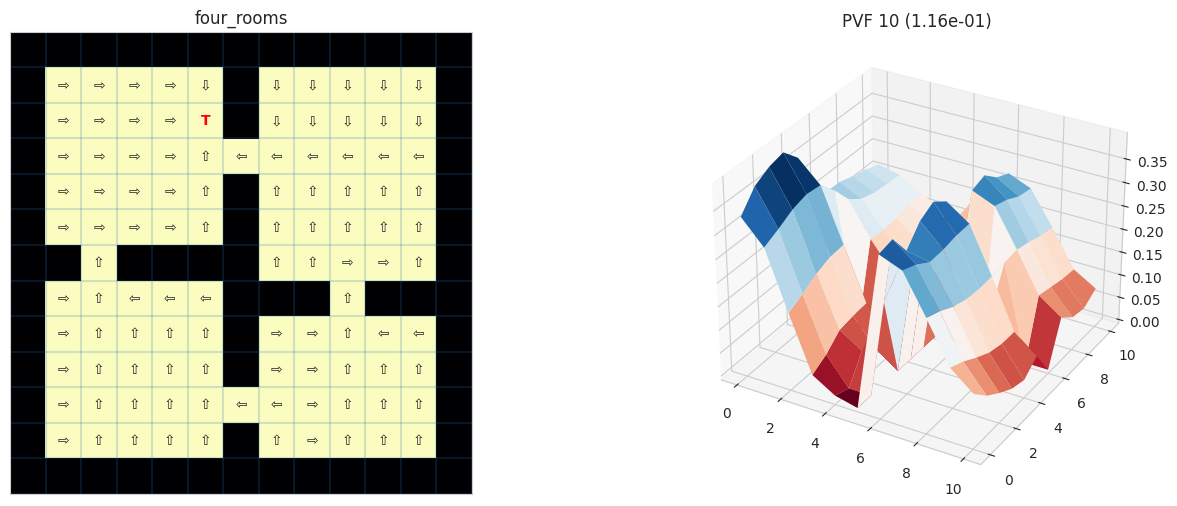

In [7]:
env  = GridWorld(grid = 'four_rooms', diffusion = 'normalised')

for i in range(10):
    V    = env.render(i)

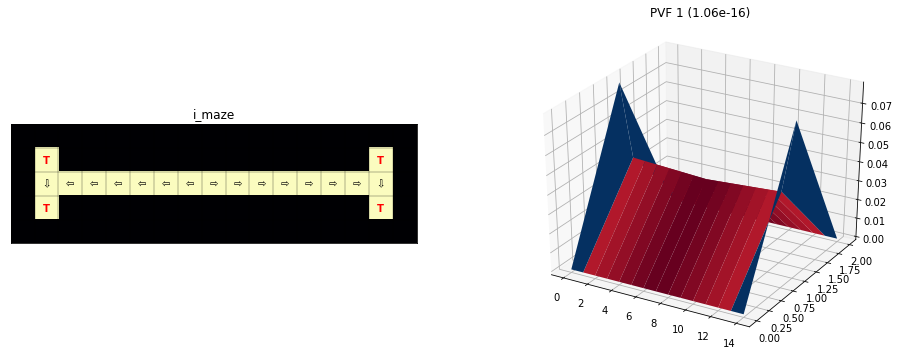

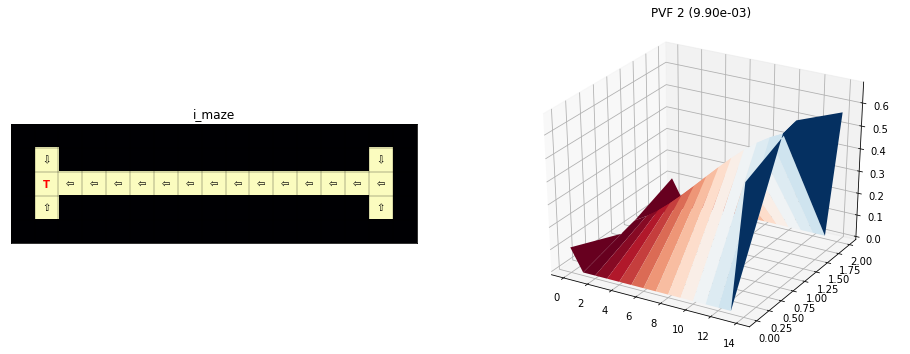

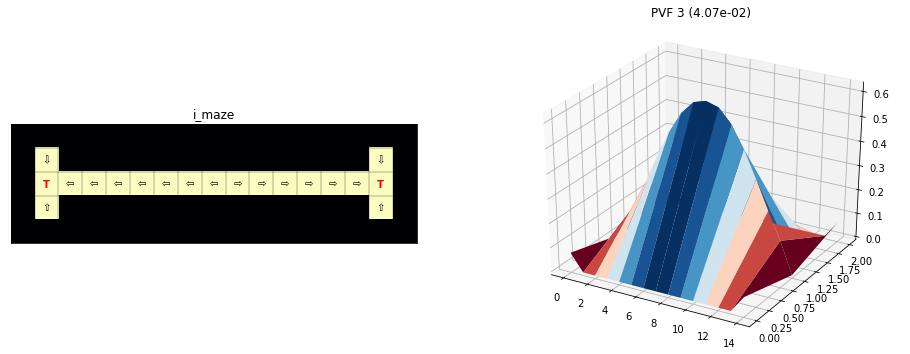

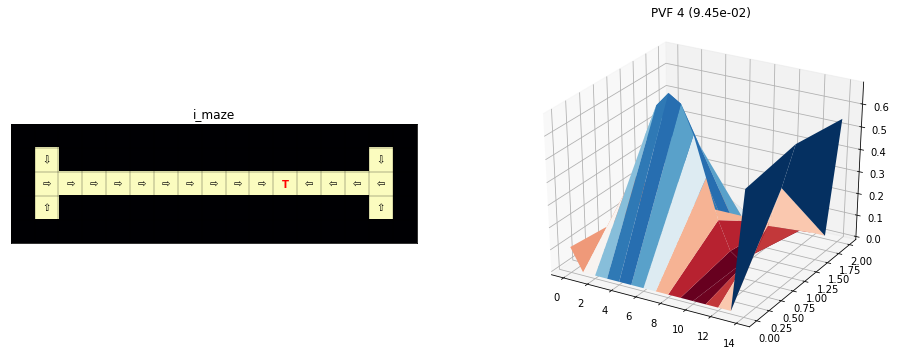

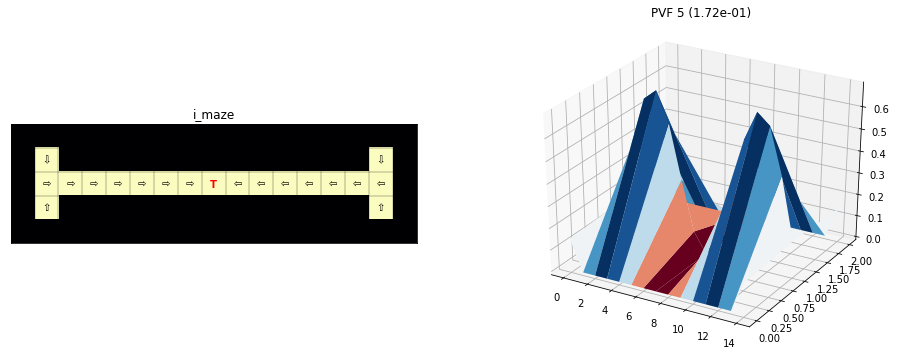

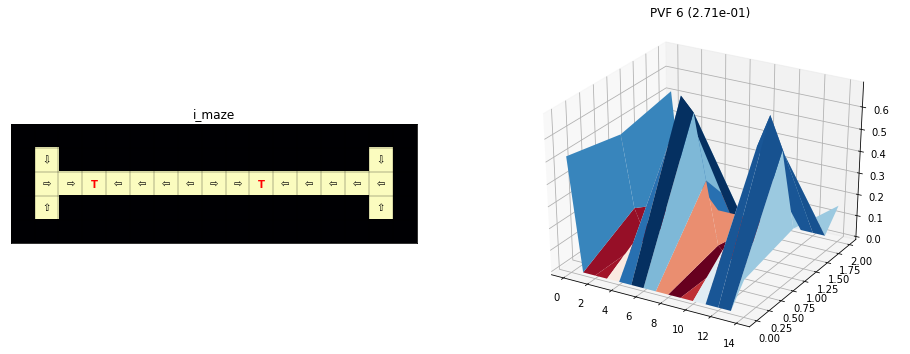

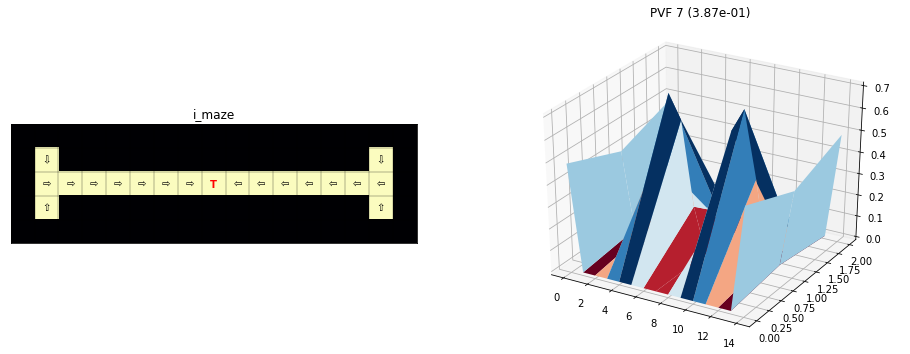

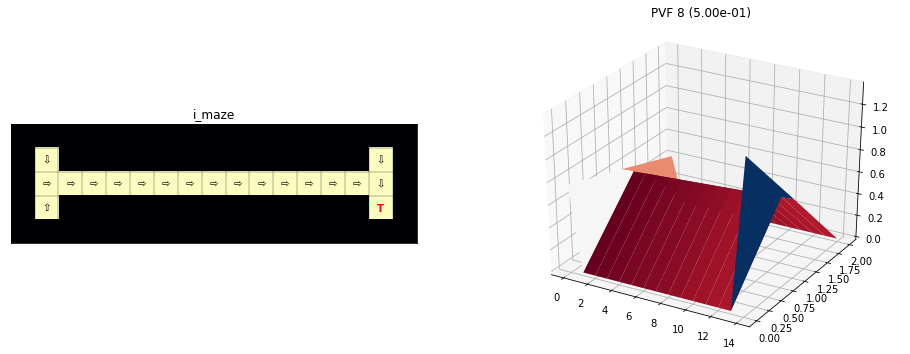

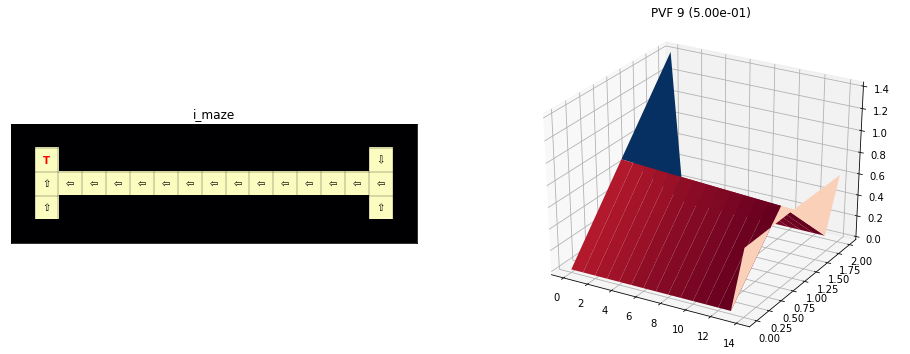

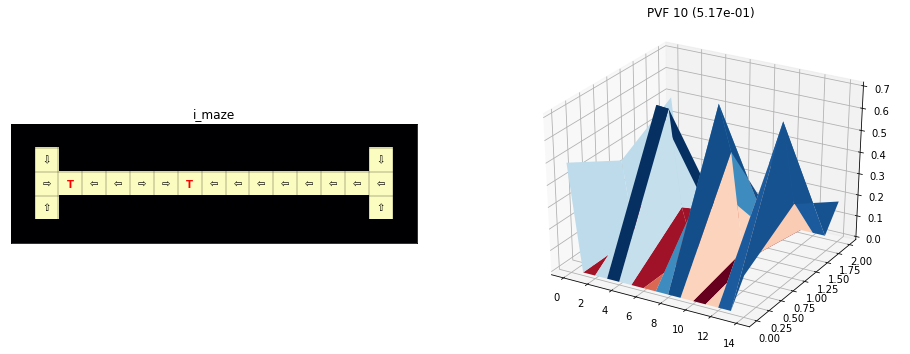

In [5]:
env  = GridWorld(grid = 'i_maze', diffusion = 'normalised')

for i in range(10):
    V    = env.render(i)

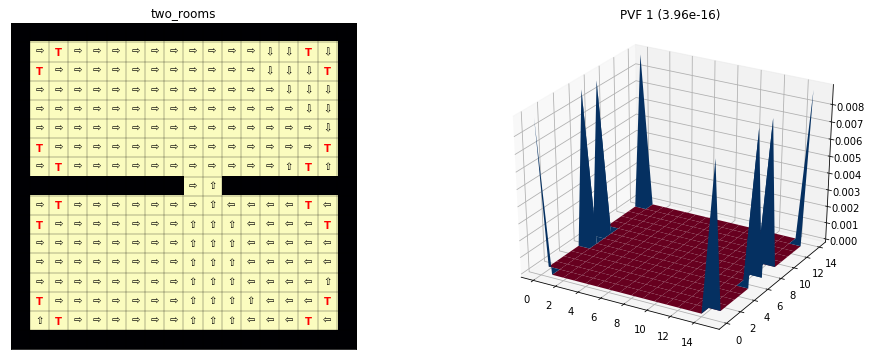

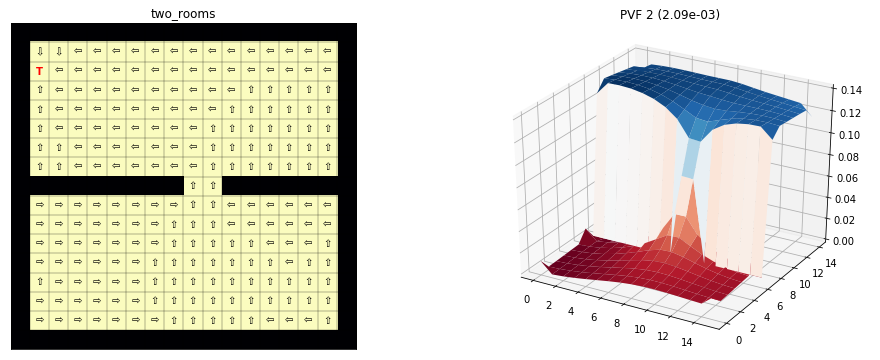

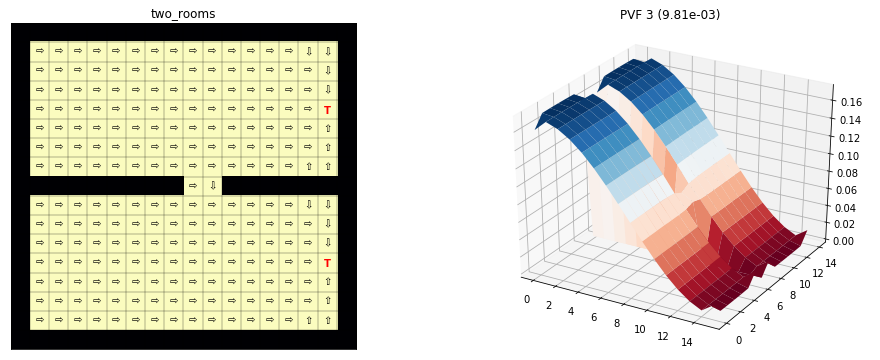

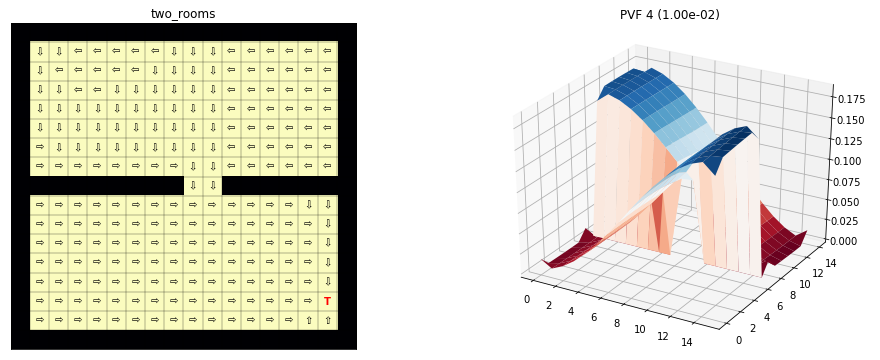

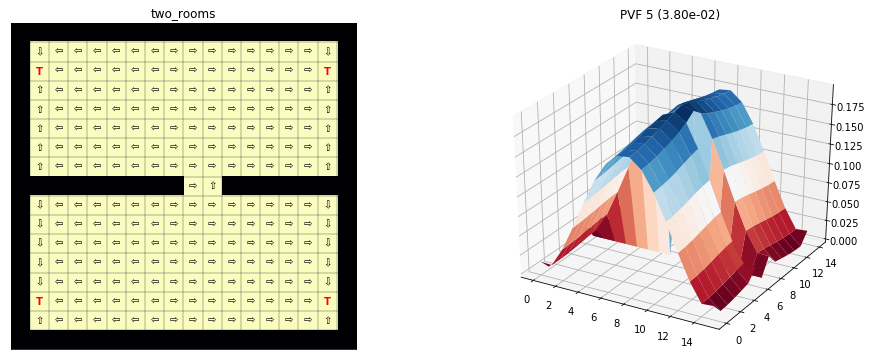

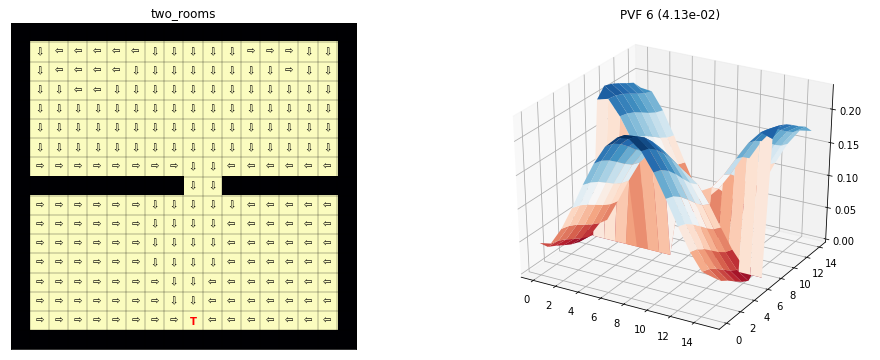

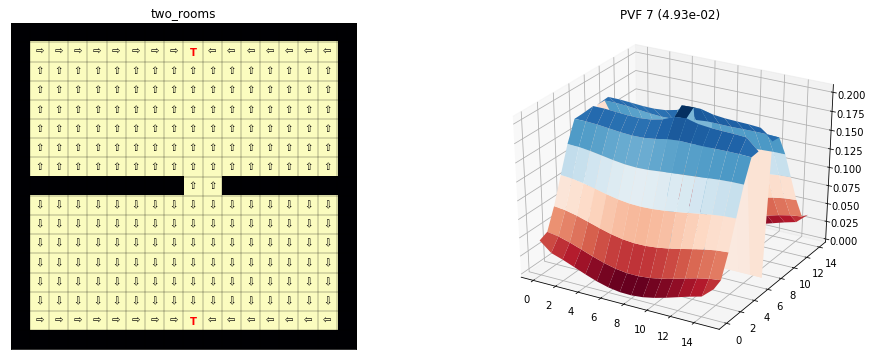

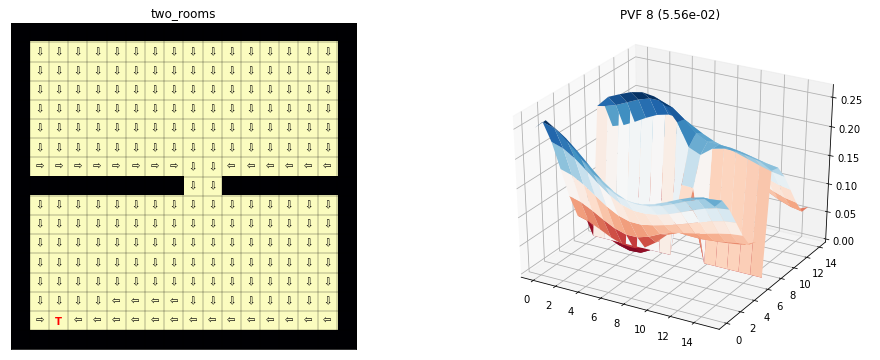

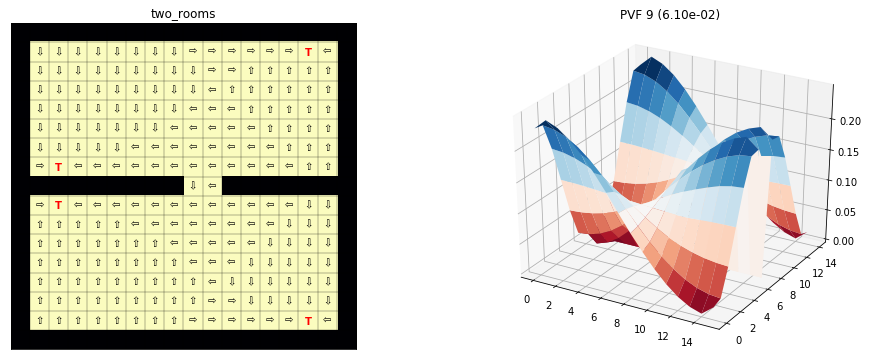

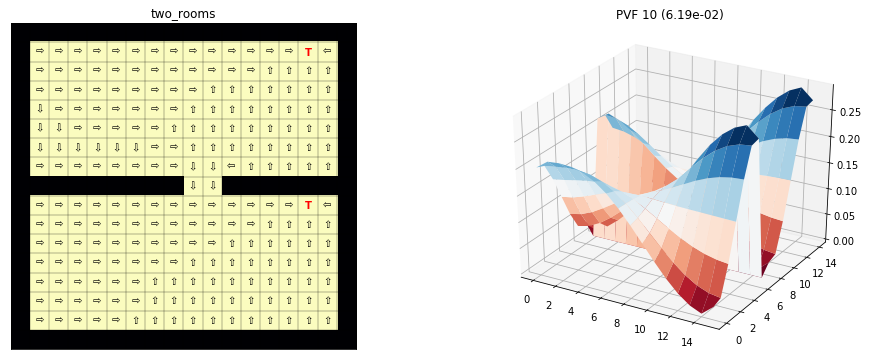

In [6]:
env  = GridWorld(grid = 'two_rooms', diffusion = 'normalised')

for i in range(10):
    V    = env.render(i, p = 0.8) # Learns a more interesting policy

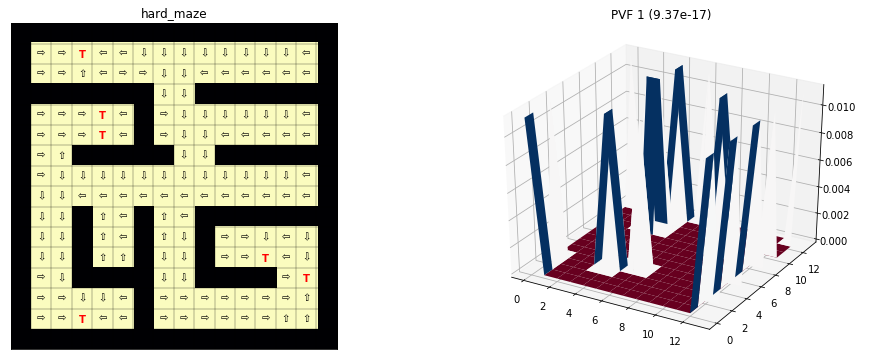

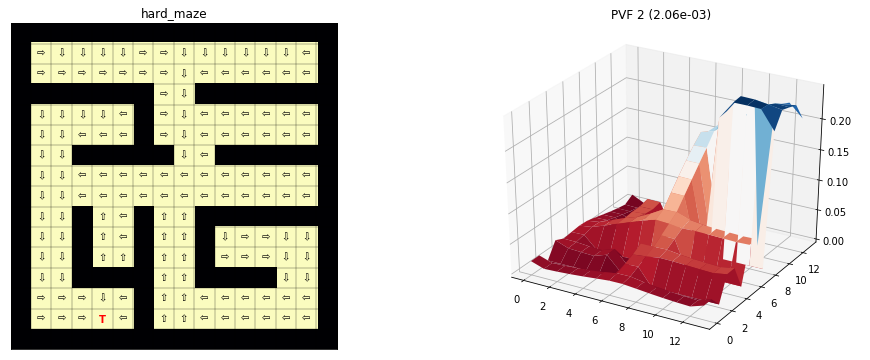

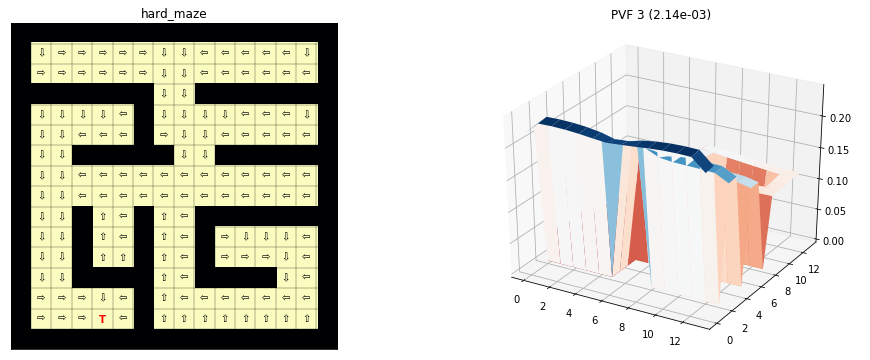

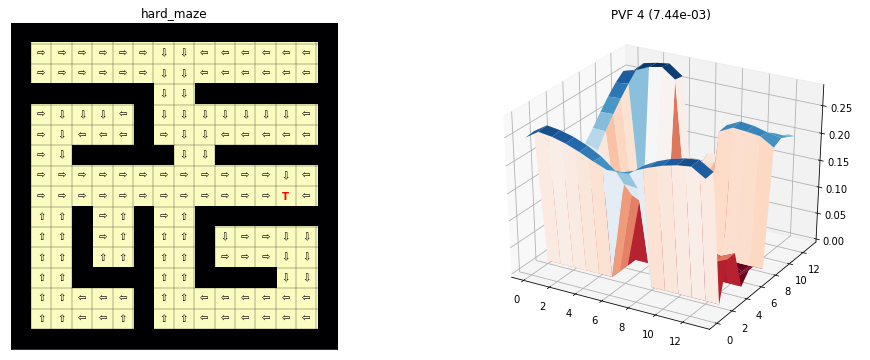

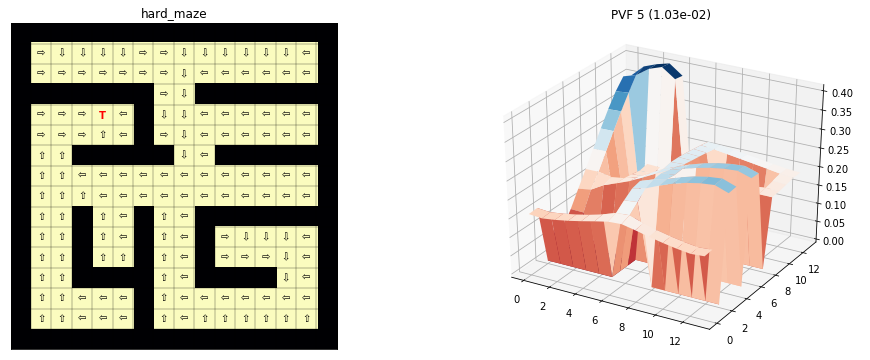

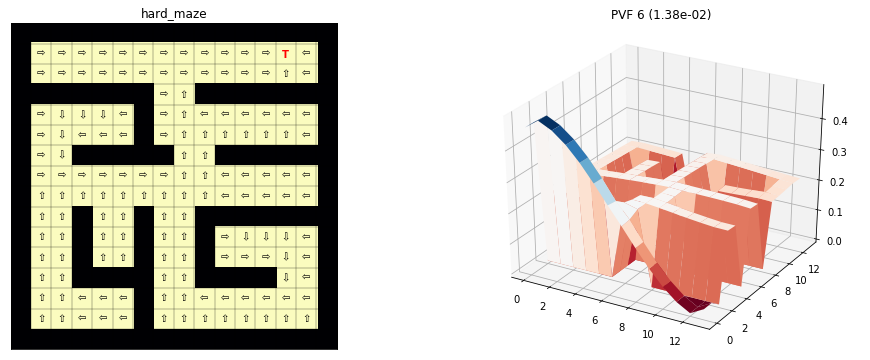

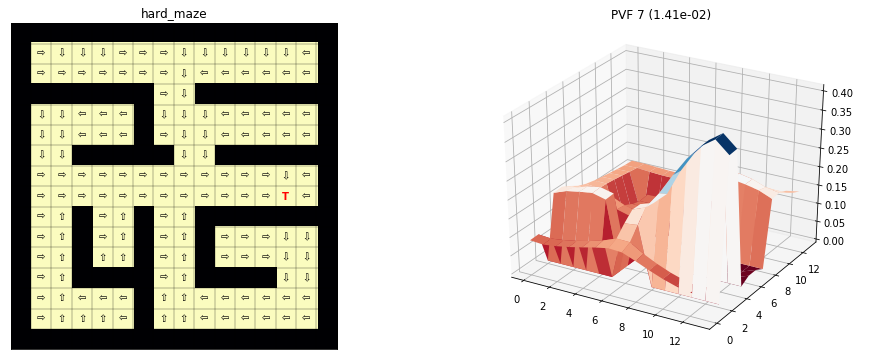

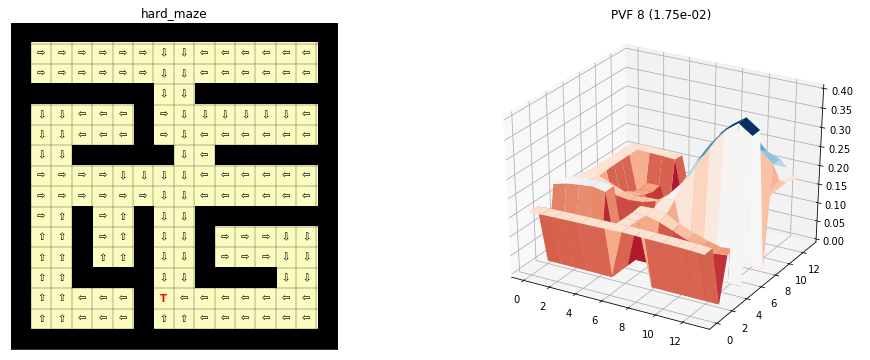

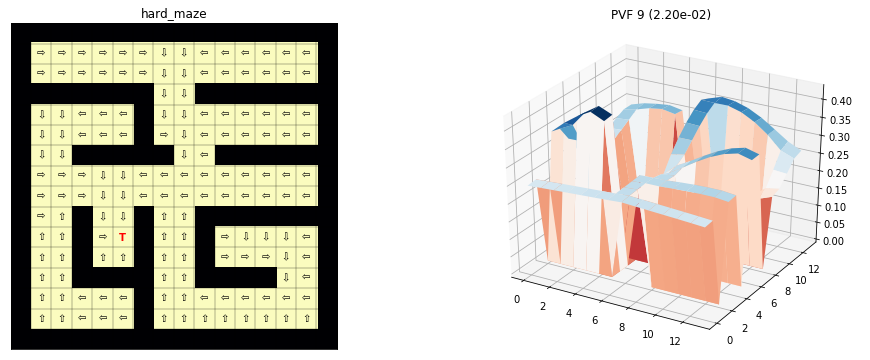

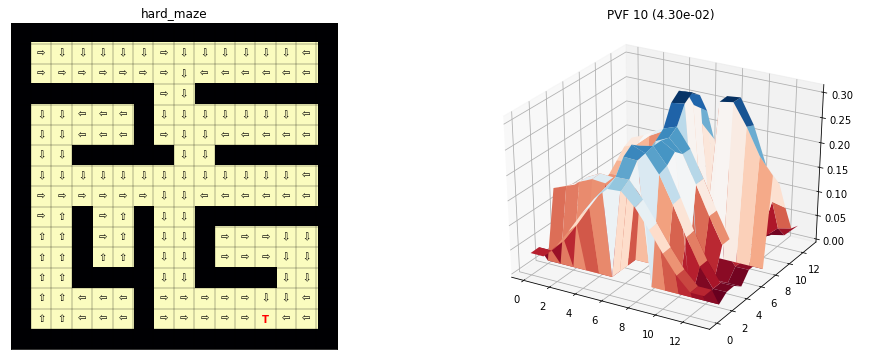

In [7]:
env  = GridWorld(grid = 'hard_maze', diffusion = 'normalised')

for i in range(10):
    V    = env.render(i)

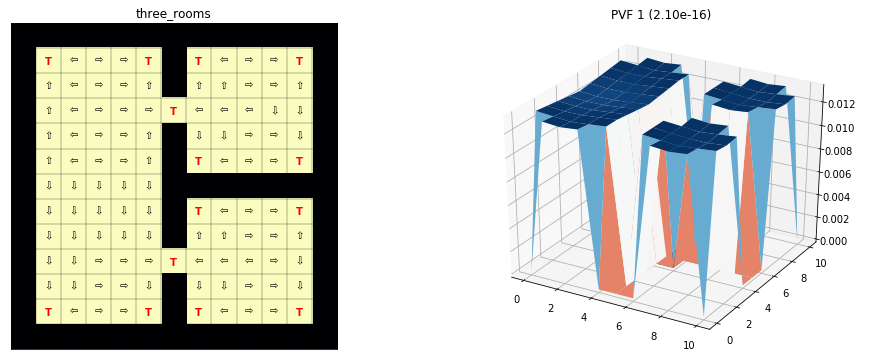

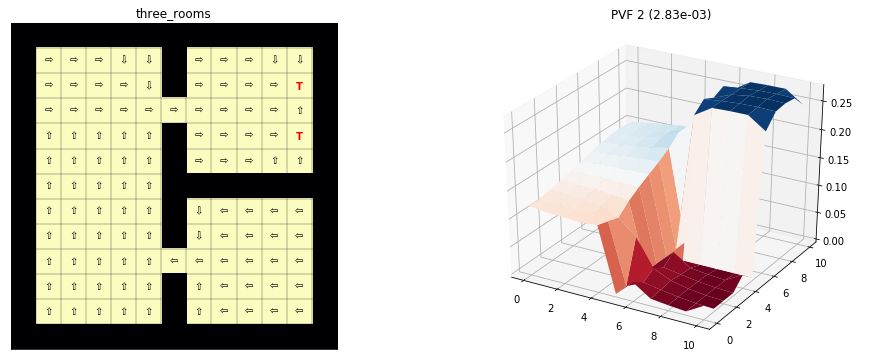

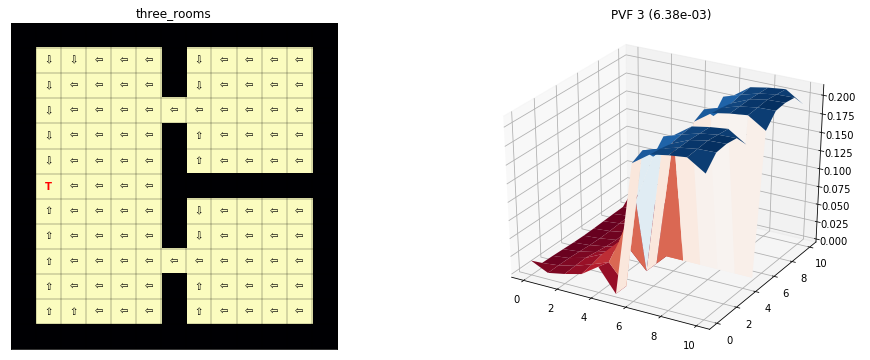

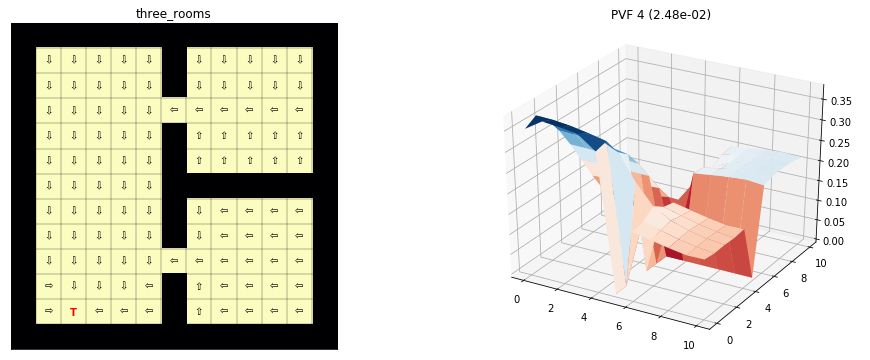

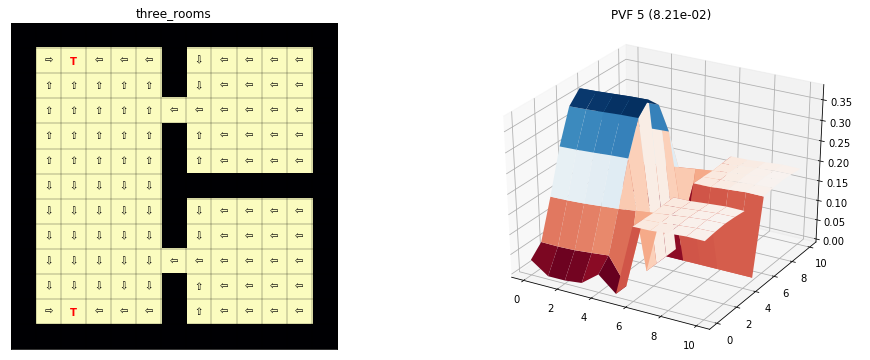

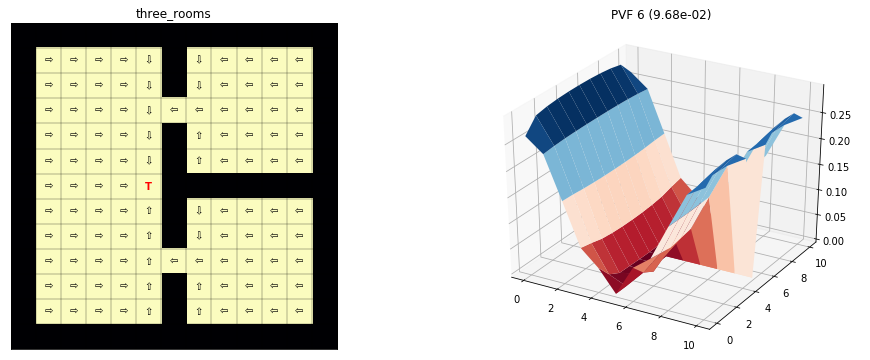

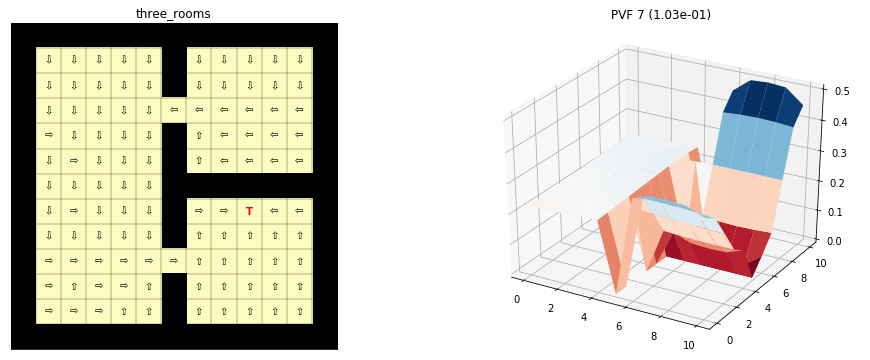

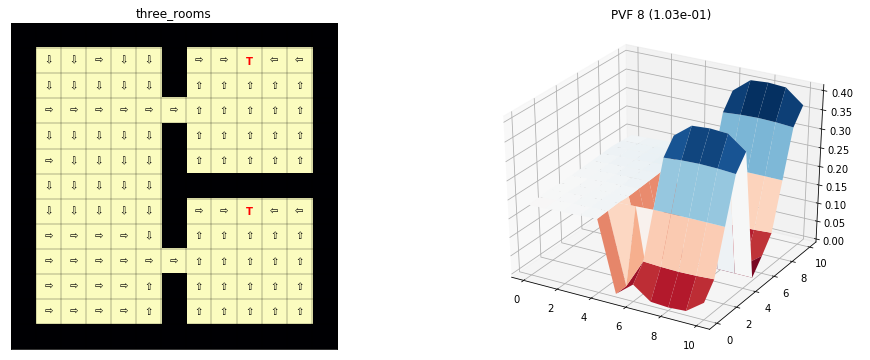

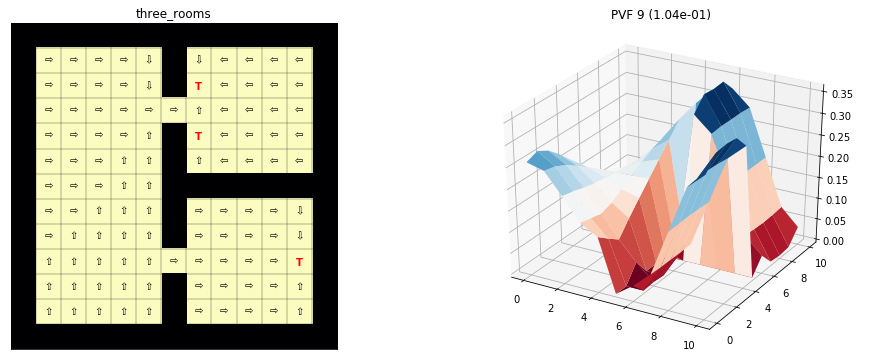

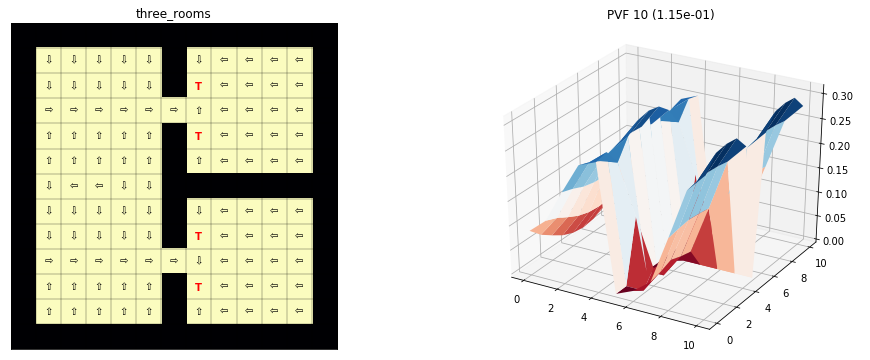

In [8]:
env  = GridWorld(grid = 'three_rooms', diffusion = 'normalised')

for i in range(10):
    V    = env.render(i)

In [ ]:
env  = GridWorld(grid = 'four_rooms', diffusion = 'normalised')
anim = env.render(0, animate = True)

env  = GridWorld(grid = 'i_maze', diffusion = 'normalised')
anim = env.render(2, animate = True)

env  = GridWorld(grid = 'two_rooms', diffusion = 'normalised')
anim = env.render(6, animate = True)

env  = GridWorld(grid = 'hard_maze', diffusion = 'normalised')
anim = env.render(4, animate = True)

env  = GridWorld(grid = 'three_rooms', diffusion = 'normalised')
anim = env.render(0, animate = True)

env  = GridWorld(grid = 'three_rooms', diffusion = 'normalised')
anim = env.render(5, animate = True)